In [1]:
#%jsroot on
from IPython.display import Image, display, clear_output
import ROOT
import math
import numpy as np
import uproot
#import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import json

#ROOT.gROOT.SetBatch(True)

In [2]:
# --- 1. Create bin edges using vectorized operations ---

# Define logarithmic bins between 0.002 and pi/2
nbins = 100
bins = np.logspace(np.log10(0.002), np.log10(np.pi/2), num=nbins+1)
# Create mirrored bins with a transformation and remove the first element for overlap avoidance
newbins = (np.pi - bins)[::-1][1:]
bin_edge = np.concatenate([bins, newbins])

# --- 2. Helper Functions ---

def divideBinWidth(h):
    """Divide the content and error of each bin by its bin width."""
    for b in range(h.GetNbinsX()):
        content = h.GetBinContent(b+1)
        error = h.GetBinError(b+1)
        width = h.GetBinWidth(b+1)
        h.SetBinContent(b+1, content / width)
        h.SetBinError(b+1, error / width)
    return h

def Proj2D_X(h, ymin, ymax, hname="XXX"):
    """
    Project a 2D histogram along X in the range [ymin, ymax].
    """
    imin = h.GetYaxis().FindBin(ymin)
    imax = h.GetYaxis().FindBin(ymax) - 1
    proj_x = h.ProjectionX(hname, imin, imax)
    ROOT.SetOwnership(proj_x, True)
    return proj_x

def prepare_histogram(unf, hist_prefix, eijbins, normalization):
    """
    Prepare a 1D histogram from a ROOT file using multiple bins.
    
    Arguments:
      unf          : The ROOT file containing unfolded histograms.
      hist_prefix  : The prefix for histogram names (e.g., "UNFOLD_Eij_Bin").
      eijbins      : List of bin edges for weighting.
      normalization: Normalization factor.
    
    Returns:
      A 1D histogram with bin contents scaled and divided by the bin width.
    """
    hdata = unf.Get(f'{hist_prefix}0')
    hdata.Scale(0.)
    hdata.SetDirectory(0)
    n_bins = len(eijbins) - 1
    for i in range(n_bins):
        hist = unf.Get(f'{hist_prefix}{i}')
        hist.SetDirectory(0)
        # Scale each histogram by the average of the bin edges
        weight = (eijbins[i] + eijbins[i+1]) / 2.
        hist.Scale(weight)
        hdata.Add(hist)
    hdata = divideBinWidth(hdata)
    hdata.Scale(1. / normalization)
    return hdata

def build_histogram(src, h1d_name, h2d_name, label_prefix, bins, normalization=1.0, apply_divide=True):
    """
    Build a 1D histogram by projecting slices from a 2D histogram.

    Parameters:
        src            : The ROOT file to get histograms from.
        h1d_name       : Name of the base 1D histogram.
        h2d_name       : Name of the 2D histogram to be projected.
        label_prefix   : Prefix for the label used in projections.
        bins           : List or array of bin edges (e.g., eijbins2).
        normalization  : Normalization factor.
        apply_divide   : If True, apply devideBinWidth and normalization scaling.
    
    Returns:
        The built and (optionally) normalized 1D histogram.
    """
    h1d = src.Get(h1d_name).Clone(f"{label_prefix}_EEC_r")
    h1d.Scale(0.)
    h1d.SetDirectory(0)
    
    h2d = src.Get(h2d_name)
    
    # Loop over the bin ranges and add the projected slices
    for i in range(len(bins) - 1):
        proj = Proj2D_X(h2d, bins[i], bins[i+1], f"{label_prefix}_Eij_Bin{i}")
        proj.SetDirectory(0)
        proj.Scale((bins[i] + bins[i+1]) / 2.)
        h1d.Add(proj)
    
    if apply_divide:
        h1d = divideBinWidth(h1d)
        h1d.Scale(1. / normalization)
    
    return h1d

def fill_TGraph(graph, hist):
    """
    Fill a ROOT TGraphErrors with points taken from a histogram.
    
    For each bin in the histogram, the x-position is set to bin center + 0.5.
    """
    nbins = hist.GetNbinsX()
    for b in range(nbins):
        content = hist.GetBinContent(b+1)
        error = hist.GetBinError(b+1)
        xcenter = hist.GetBinCenter(b+1)
        graph.SetPoint(b, b+0.5, content)
        graph.SetPointError(b, 0, error)
    return graph

def fill_TGraph_corr(graph, hist, corr):
    """
    Fill a ROOT TGraphErrors with points taken from a histogram.
    
    For each bin in the histogram, the x-position is set to bin center + 0.5.
    """
    nbins = hist.GetNbinsX()
    for b in range(nbins):
        content = hist.GetBinContent(b+1)*corr[b]
        error = hist.GetBinError(b+1)*corr[b]
        xcenter = hist.GetBinCenter(b+1)
        graph.SetPoint(b, b+0.5, content)
        graph.SetPointError(b, 0, error)
    return graph

def draw_lines(x_positions, y_low, y_high, lw=2):
    """
    Helper to draw vertical lines at given x positions from y_low to y_high.
    Returns a list of drawn lines.
    """
    lines = []
    for x in x_positions:
        line = ROOT.TLine(x, y_low, x, y_high)
        line.SetLineWidth(lw)
        line.Draw()
        lines.append(line)
    return lines

# --- 5. Compute Tick Positions for Axis Labels ---

# Define tick label positions and text
#labels   = np.array([0.01, 0.1, 1, np.pi-1, np.pi-0.1, np.pi-0.01])
poslabels = np.array([0.01, 0.1, 1])
t_labels = ['0.01', '0.1', '1', '#pi-1', '#pi-0.1', '#pi-0.01']


file = ROOT.TFile('h_Data_2d.root', 'r')
hdata1 = file.Get('EEC_r_pos')

# Extract bin centers from hdata1 for fractional positions:
nbins_arr = np.array([hdata1.GetBinCenter(b+1) for b in range(hdata1.GetNbinsX())])
# Find fractional indices corresponding to labels via interpolation:
lower_idx = np.searchsorted(nbins_arr, poslabels, side='right') - 1
lower_idx = np.clip(lower_idx, 0, len(nbins_arr)-2)
x0 = nbins_arr[lower_idx]
x1 = nbins_arr[lower_idx+1]
fractional = (poslabels - x0) / (x1 - x0)
posindices = lower_idx + fractional
newindices = (200 - posindices)[::-1]
indices = np.concatenate([posindices, newindices])


# Points to extrapolate using list comprehensions
points_to_extrapolate = ([0.002 + 0.001 * i for i in range(9)] +
                         [0.01 + 0.01 * i for i in range(10)] +
                         [0.1 + 0.1 * i for i in range(10)])
points_to_extrapolate = np.array(points_to_extrapolate)
# Compute fractional indices for extrapolation points:
lower_idx_ex = np.searchsorted(nbins_arr, points_to_extrapolate, side='right') - 1
lower_idx_ex = np.clip(lower_idx_ex, 0, len(nbins_arr)-2)
x0_ex = nbins_arr[lower_idx_ex]
x1_ex = nbins_arr[lower_idx_ex+1]
fractional_ex = (points_to_extrapolate - x0_ex) / (x1_ex - x0_ex)
p_indices = lower_idx_ex + fractional_ex  # Final fractional indices

# Bin edges for E_ij
eijbins2 = [0.0, 0.0001, 0.0002, 0.0005, 0.00075, 0.001, 0.00125, 0.0015, 0.00175,
            0.002, 0.00225, 0.0025, 0.00275, 0.003, 0.0035, 0.004, 0.005, 0.007, 
            0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.10, 0.15, 0.20, 0.3, 1]

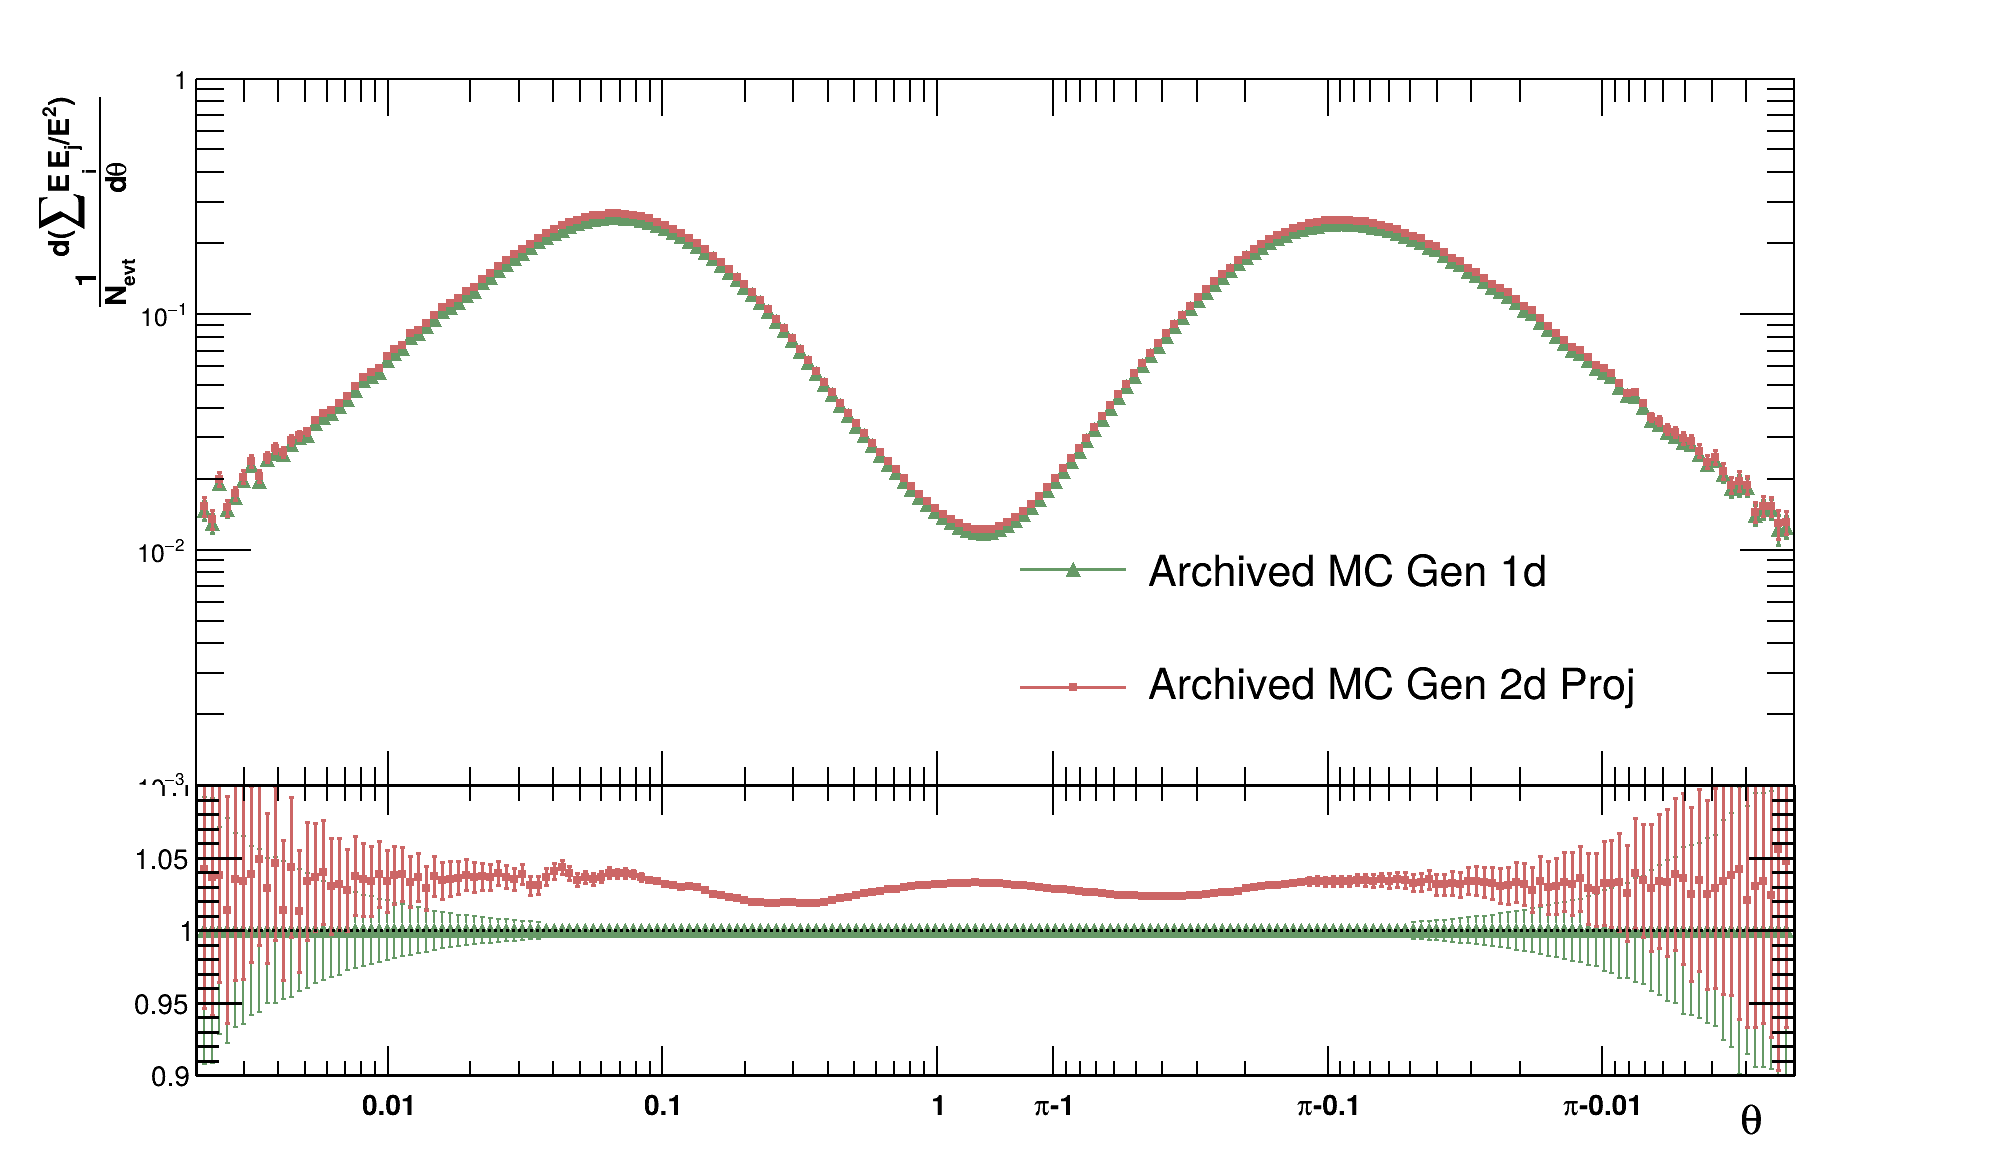

[0.9597815490536473, 0.9644471104707244, 0.9630631362786456, 0.9859673207408804, 0.9659332254330544, 0.9672831611371545, 0.9626791465366117, 0.9531753351362745, 0.9715212085111539, 0.9556237689527487, 0.986209700210852, 0.9581388135049658, 0.98686489516652, 0.9671820047908002, 0.9646007806114619, 0.961354426303558, 0.9706697546675251, 0.9691545422805722, 0.9728126907791848, 0.9636872632549994, 0.9660573005200763, 0.9670658769169366, 0.9625021508393339, 0.9669619522485667, 0.9632170698815736, 0.9629203342325706, 0.9675846845044086, 0.9645354046079195, 0.971549059625044, 0.9638028445340585, 0.9666974074822016, 0.9656010311987725, 0.9648918119470722, 0.9631298779348709, 0.9645411696977174, 0.9641923614685887, 0.96431797654845, 0.9620285855383491, 0.964376051033896, 0.9658311501538936, 0.962411593660685, 0.969905841316161, 0.9698038184208689, 0.964320178751715, 0.9608368251286862, 0.9581847214948457, 0.9618547861319076, 0.9663176701895813, 0.9644768862494532, 0.9659217442553374, 0.96426814

Info in <TCanvas::Print>: png file EEC_binning_cor.png has been created


In [3]:
#file1 = ROOT.TFile('hgen_LEP1MC1994_recons_aftercut_v2.root', 'r')
file = ROOT.TFile('hgen_LEP1MC1994_recons_aftercut.root', 'r')

hdata1 = file.Get('EEC_r')
#hdata2 = file.Get('EEC2d_r')
#hdata3 = file.Get('EEC_r_cross')

normalization = file.Get('N').GetBinContent(2)
#normalization = file.Get('N').GetBinContent(2)

hdata1.Scale(1./normalization)
#hdata2.Scale(1./normalization)

hdata1 = divideBinWidth(hdata1)
#hdata2 = divideBinWidth(hdata2)

hdata2 = build_histogram(file, 'EEC_r', 'EEC2d_r', 'proj', eijbins2, normalization, apply_divide=True)

# --- 4. Create TGraphErrors for Data and Ratios ---

data1_eec = ROOT.TGraphErrors()
data2_eec = ROOT.TGraphErrors()

ratio1   = ROOT.TGraphErrors()
ratio2   = ROOT.TGraphErrors()


# Fill TGraphErrors using the helper function
fill_TGraph(data1_eec, hdata1)
fill_TGraph(data2_eec, hdata2)


corr_bin = []
# Create ratio graphs: here we use hdata1 as a denominator for all ratios.
nb = hdata1.GetNbinsX()
for b in range(nb):
    x_val = hdata1.GetBinCenter(b+1)
    den = hdata1.GetBinContent(b+1) if hdata1.GetBinContent(b+1) != 0 else 1.0  # avoid div-by-zero
    ratio1.SetPoint(b, b+0.5, hdata1.GetBinContent(b+1)/den)
    ratio1.SetPointError(b, 0, hdata1.GetBinError(b+1)/den)
    ratio2.SetPoint(b, b+0.5, hdata2.GetBinContent(b+1)/den)
    ratio2.SetPointError(b, 0, hdata2.GetBinError(b+1)/den)
    corr_bin += [1./(hdata2.GetBinContent(b+1)/den)]

# --- 6. Set Up ROOT Canvas and Style ---

ROOT.gStyle.SetLineWidth(0)
ROOT.gStyle.SetOptStat(0)

xmin, xmax = 0., 200.
ymin, ymax = 0.001, 1.
rymin, rymax = 0.9, 1.1
rylen = rymax - rymin

c4 = ROOT.TCanvas("tmp", "", 0, 0, 2000, 1200)
#c4 = ROOT.TCanvas("tmp", "", 0, 0, 000, 1200)
c4.Divide(1, 2)
pad1 = ROOT.TPad("", "", 0, 0.33, 1, 1)
pad2 = ROOT.TPad("", "", 0, 0, 1, 0.33)
pad1.SetFrameLineWidth(0)
pad2.SetFrameLineWidth(0)
pad1.SetBottomMargin(0.0)
pad2.SetTopMargin(0.0)
pad2.SetBottomMargin(0.25)
pad1.Draw()
pad2.Draw()

# --- 7. Draw Upper Pad (Data) ---

pad1.cd()
pad1.SetLogy()
data1_eec.SetMarkerSize(2)
data1_eec.SetMarkerStyle(22)
data1_eec.SetMarkerColor(ROOT.kGreen-5)
data1_eec.SetLineColor(ROOT.kGreen-5)
data1_eec.SetLineWidth(3)
data1_eec.GetXaxis().SetTickLength(0)
data1_eec.GetXaxis().SetLabelSize(0)
data1_eec.GetXaxis().SetRangeUser(xmin, xmax)
data1_eec.GetYaxis().SetRangeUser(ymin, ymax)
data1_eec.Draw("ap")

data2_eec.SetMarkerSize(1)
data2_eec.SetMarkerStyle(21)
data2_eec.SetMarkerColor(ROOT.kRed-6)
data2_eec.SetLineColor(ROOT.kRed-6)
data2_eec.SetLineWidth(3)
data2_eec.Draw("samep")


# Redraw again to ensure proper layering
data1_eec.Draw("samep")
data2_eec.Draw("samep")


# Draw additional axis and lines
f = ROOT.TF1("f", "log10(x)", ymin, ymax)
newaxis0 = ROOT.TGaxis(p_indices[0], ymin, p_indices[0], ymax, "f", 505, "-G")
newaxis0.SetLabelSize(0)
newaxis0.SetLineWidth(2)
newaxis0.Draw()

newaxis1 = ROOT.TGaxis(xmax - p_indices[0], ymin, xmax - p_indices[0], ymax, "f", 505, "+G")
newaxis1.SetLabelSize(0)
newaxis1.SetLineWidth(2)
newaxis1.Draw()

l0 = ROOT.TLine(xmin, ymax, xmax, ymax)
l0.SetLineWidth(2)
l0.Draw()

l1 = ROOT.TLine(xmin, ymin, xmax, ymin)
l1.SetLineWidth(2)
l1.Draw()

# Draw tick marks based on t_labels and indices
ticks = []
for pos in indices:
    ticks.extend(draw_lines([pos], 0.7*ymax, ymax))
    ticks.extend(draw_lines([pos], ymin, ymin + ymin*0.4))

for pt in p_indices:
    ticks.extend(draw_lines([xmin+pt], 0.8*ymax, ymax))
    ticks.extend(draw_lines([xmax-pt], 0.8*ymax, ymax))
    ticks.extend(draw_lines([xmin+pt], ymin, ymin + ymin*0.2))
    ticks.extend(draw_lines([xmax-pt], ymin, ymin + ymin*0.2))

txt1 = ROOT.TLatex()
txt1.SetTextSize(0.04)
txt1.SetTextAlign(22)
txt1.SetTextAngle(90)
txt1.DrawLatex(-14, 0.3*ymax, "#frac{1}{N_{evt}}#frac{d(#sumE_{i}E_{j}/E^{2})}{d#theta}")

legend = ROOT.TLegend(0.5, 0.05, 0.8, 0.35)
legend.AddEntry(data1_eec, "Archived MC Gen 1d", "alp")
legend.AddEntry(data2_eec, "Archived MC Gen 2d Proj", "alp")
legend.SetTextSize(0.06)
legend.SetFillStyle(0)
legend.Draw("same")

# --- 8. Draw Lower Pad (Ratio) ---

pad2.cd()
ratio1.SetLineWidth(2)
ratio1.GetXaxis().SetTickLength(0)
ratio1.GetXaxis().SetLabelSize(0)
ratio1.GetXaxis().SetRangeUser(xmin, xmax)
ratio1.SetMarkerSize(2)
ratio1.SetMarkerStyle(22)
ratio1.SetMarkerColor(ROOT.kGreen-5)
ratio1.SetLineColor(ROOT.kGreen-5)
ratio1.Draw("ap")
ratio1.GetYaxis().SetRangeUser(rymin, rymax)
ratio1.GetYaxis().SetNdivisions(505)
ratio1.GetYaxis().SetLabelSize(0.08)

ratio2.SetMarkerSize(1)
ratio2.SetMarkerStyle(21)
ratio2.SetMarkerColor(ROOT.kRed-6)
ratio2.SetLineColor(ROOT.kRed-6)
ratio2.SetLineWidth(3)
ratio2.Draw("samep")


# Draw tick labels along x-axis
for pos, lab in zip(indices, t_labels):
    tex = ROOT.TLatex()
    tex.SetTextSize(0.08)
    tex.SetTextAlign(22)
    tex.DrawLatex(pos, rymin - 0.1*rylen, lab)
    tick = ROOT.TLine(pos, rymin, pos, rymin + rylen*0.1)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks.append(tick)

for pos in indices:
    tick = ROOT.TLine(pos, rymax - rylen*0.1, pos, rymax)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks.append(tick)

for pt in p_indices:
    ticks.extend(draw_lines([xmin+pt], rymin, rymin+rylen*0.05))
    ticks.extend(draw_lines([xmax-pt], rymin, rymin+rylen*0.05))
    ticks.extend(draw_lines([xmin+pt], rymax-rylen*0.05, rymax))
    ticks.extend(draw_lines([xmax-pt], rymax-rylen*0.05, rymax))

newaxis2 = ROOT.TGaxis(p_indices[0], rymin, p_indices[0], rymax, rymin, rymax, 505, "-L")
newaxis2.SetLabelSize(0)
newaxis2.SetLineWidth(3)
newaxis2.Draw()

newaxis3 = ROOT.TGaxis(xmax-p_indices[0], rymin, xmax-p_indices[0], rymax, rymin, rymax, 505, "+L")
newaxis3.SetLabelSize(0)
newaxis3.SetLineWidth(3)
newaxis3.Draw()

l2 = ROOT.TLine(0, rymax, 200, rymax)
l2.SetLineWidth(3)
l2.Draw()

l3 = ROOT.TLine(0, rymin, 200, rymin)
l3.SetLineWidth(3)
l3.Draw()

l4 = ROOT.TLine(0,1,200,1)
l4.SetLineWidth(3)
l4.SetLineStyle(2)
l4.Draw()

txt2 = ROOT.TLatex()
txt2.SetTextSize(0.12)
txt2.SetTextAlign(22)
txt2.DrawLatex(195, rymin - 0.15*rylen, "#theta")

#c4.Update()
c4.SaveAs('EEC_binning_cor.png')
c4.Close()
clear_output(wait=True)
display(Image("EEC_binning_cor.png"))

print(corr_bin)

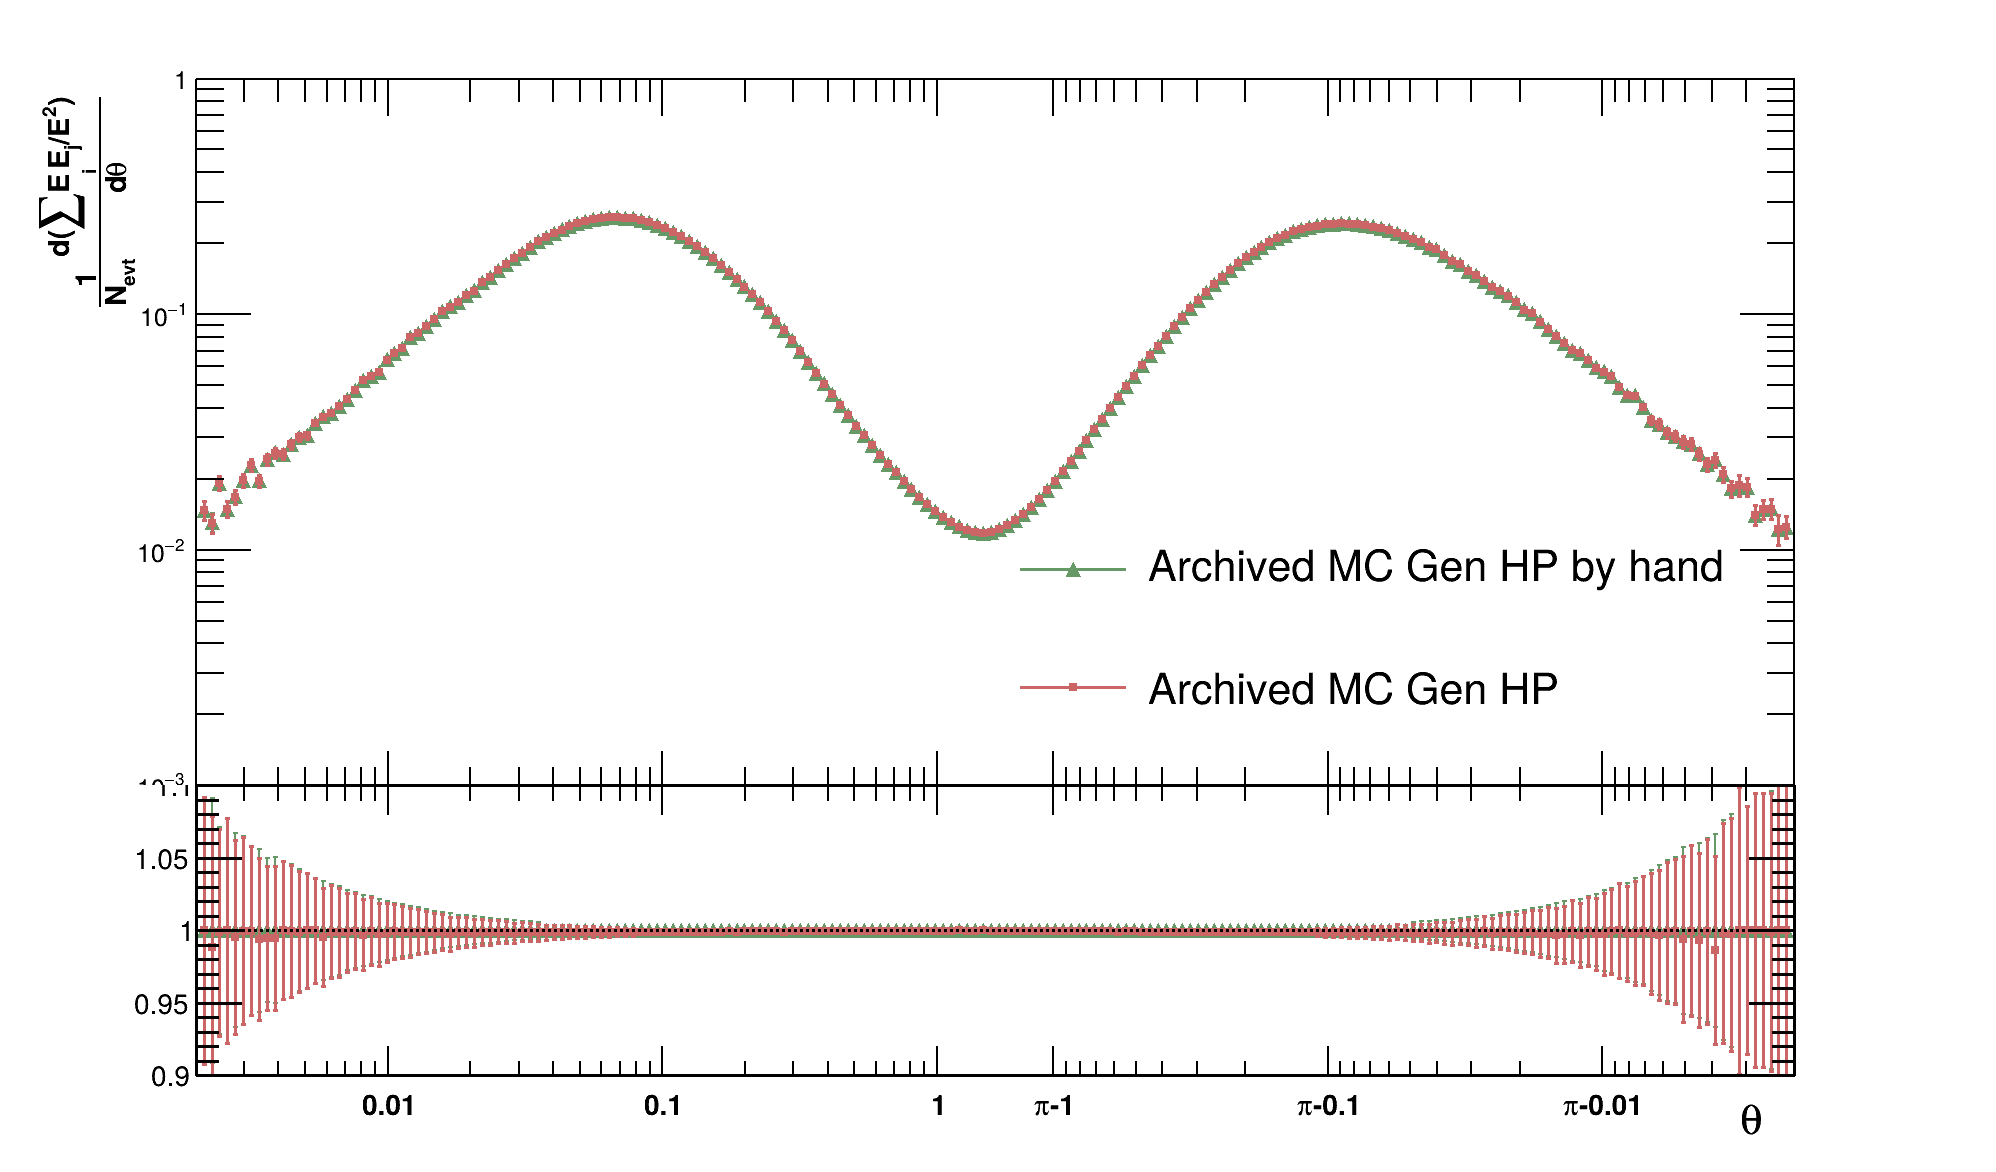

Info in <TCanvas::Print>: png file EEC_track_sele_cor.png has been created


In [4]:
file1 = ROOT.TFile('hgen_LEP1MC1994_recons_aftercut_v2.root', 'r')
file2 = ROOT.TFile('hgen_LEP1MC1994_recons_aftercut.root', 'r')

hdata1 = file1.Get('EEC_r')
hdata2 = file2.Get('EEC_r')
#hdata3 = file.Get('EEC_r_cross')

normalization1 = file1.Get('N').GetBinContent(2)
normalization2 = file2.Get('N').GetBinContent(2)

hdata1.Scale(1./normalization1)
hdata2.Scale(1./normalization2)

hdata1 = divideBinWidth(hdata1)
hdata2 = divideBinWidth(hdata2)

# --- 4. Create TGraphErrors for Data and Ratios ---

data1_eec = ROOT.TGraphErrors()
data2_eec = ROOT.TGraphErrors()

ratio1   = ROOT.TGraphErrors()
ratio2   = ROOT.TGraphErrors()


# Fill TGraphErrors using the helper function
fill_TGraph(data1_eec, hdata1)
fill_TGraph(data2_eec, hdata2)


# Create ratio graphs: here we use hdata1 as a denominator for all ratios.
nb = hdata1.GetNbinsX()
for b in range(nb):
    x_val = hdata1.GetBinCenter(b+1)
    den = hdata1.GetBinContent(b+1) if hdata1.GetBinContent(b+1) != 0 else 1.0  # avoid div-by-zero
    ratio1.SetPoint(b, b+0.5, hdata1.GetBinContent(b+1)/den)
    ratio1.SetPointError(b, 0, hdata1.GetBinError(b+1)/den)
    ratio2.SetPoint(b, b+0.5, hdata2.GetBinContent(b+1)/den)
    ratio2.SetPointError(b, 0, hdata2.GetBinError(b+1)/den)
   

# --- 6. Set Up ROOT Canvas and Style ---

ROOT.gStyle.SetLineWidth(0)
ROOT.gStyle.SetOptStat(0)

xmin, xmax = 0., 200.
ymin, ymax = 0.001, 1.
rymin, rymax = 0.9, 1.1
rylen = rymax - rymin

c4 = ROOT.TCanvas("tmp", "", 0, 0, 2000, 1200)
c4.Divide(1, 2)
pad1 = ROOT.TPad("", "", 0, 0.33, 1, 1)
pad2 = ROOT.TPad("", "", 0, 0, 1, 0.33)
pad1.SetFrameLineWidth(0)
pad2.SetFrameLineWidth(0)
pad1.SetBottomMargin(0.0)
pad2.SetTopMargin(0.0)
pad2.SetBottomMargin(0.25)
pad1.Draw()
pad2.Draw()

# --- 7. Draw Upper Pad (Data) ---

pad1.cd()
pad1.SetLogy()
data1_eec.SetMarkerSize(2)
data1_eec.SetMarkerStyle(22)
data1_eec.SetMarkerColor(ROOT.kGreen-5)
data1_eec.SetLineColor(ROOT.kGreen-5)
data1_eec.SetLineWidth(3)
data1_eec.GetXaxis().SetTickLength(0)
data1_eec.GetXaxis().SetLabelSize(0)
data1_eec.GetXaxis().SetRangeUser(xmin, xmax)
data1_eec.GetYaxis().SetRangeUser(ymin, ymax)
data1_eec.Draw("ap")

data2_eec.SetMarkerSize(1)
data2_eec.SetMarkerStyle(21)
data2_eec.SetMarkerColor(ROOT.kRed-6)
data2_eec.SetLineColor(ROOT.kRed-6)
data2_eec.SetLineWidth(3)
data2_eec.Draw("samep")


# Redraw again to ensure proper layering
data1_eec.Draw("samep")
data2_eec.Draw("samep")


# Draw additional axis and lines
f = ROOT.TF1("f", "log10(x)", ymin, ymax)
newaxis0 = ROOT.TGaxis(p_indices[0], ymin, p_indices[0], ymax, "f", 505, "-G")
newaxis0.SetLabelSize(0)
newaxis0.SetLineWidth(2)
newaxis0.Draw()

newaxis1 = ROOT.TGaxis(xmax - p_indices[0], ymin, xmax - p_indices[0], ymax, "f", 505, "+G")
newaxis1.SetLabelSize(0)
newaxis1.SetLineWidth(2)
newaxis1.Draw()

l0 = ROOT.TLine(xmin, ymax, xmax, ymax)
l0.SetLineWidth(2)
l0.Draw()

l1 = ROOT.TLine(xmin, ymin, xmax, ymin)
l1.SetLineWidth(2)
l1.Draw()

# Draw tick marks based on t_labels and indices
ticks = []
for pos in indices:
    ticks.extend(draw_lines([pos], 0.7*ymax, ymax))
    ticks.extend(draw_lines([pos], ymin, ymin + ymin*0.4))

for pt in p_indices:
    ticks.extend(draw_lines([xmin+pt], 0.8*ymax, ymax))
    ticks.extend(draw_lines([xmax-pt], 0.8*ymax, ymax))
    ticks.extend(draw_lines([xmin+pt], ymin, ymin + ymin*0.2))
    ticks.extend(draw_lines([xmax-pt], ymin, ymin + ymin*0.2))

txt1 = ROOT.TLatex()
txt1.SetTextSize(0.04)
txt1.SetTextAlign(22)
txt1.SetTextAngle(90)
txt1.DrawLatex(-14, 0.3*ymax, "#frac{1}{N_{evt}}#frac{d(#sumE_{i}E_{j}/E^{2})}{d#theta}")

legend = ROOT.TLegend(0.5, 0.05, 0.8, 0.35)
legend.AddEntry(data1_eec, "Archived MC Gen HP by hand", "alp")
legend.AddEntry(data2_eec, "Archived MC Gen HP", "alp")
legend.SetTextSize(0.06)
legend.SetFillStyle(0)
legend.Draw("same")

# --- 8. Draw Lower Pad (Ratio) ---

pad2.cd()
ratio1.SetLineWidth(2)
ratio1.GetXaxis().SetTickLength(0)
ratio1.GetXaxis().SetLabelSize(0)
ratio1.GetXaxis().SetRangeUser(xmin, xmax)
ratio1.SetMarkerSize(2)
ratio1.SetMarkerStyle(22)
ratio1.SetMarkerColor(ROOT.kGreen-5)
ratio1.SetLineColor(ROOT.kGreen-5)
ratio1.Draw("ap")
ratio1.GetYaxis().SetRangeUser(rymin, rymax)
ratio1.GetYaxis().SetNdivisions(505)
ratio1.GetYaxis().SetLabelSize(0.08)

ratio2.SetMarkerSize(1)
ratio2.SetMarkerStyle(21)
ratio2.SetMarkerColor(ROOT.kRed-6)
ratio2.SetLineColor(ROOT.kRed-6)
ratio2.SetLineWidth(3)
ratio2.Draw("samep")


# Draw tick labels along x-axis
for pos, lab in zip(indices, t_labels):
    tex = ROOT.TLatex()
    tex.SetTextSize(0.08)
    tex.SetTextAlign(22)
    tex.DrawLatex(pos, rymin - 0.1*rylen, lab)
    tick = ROOT.TLine(pos, rymin, pos, rymin + rylen*0.1)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks.append(tick)

for pos in indices:
    tick = ROOT.TLine(pos, rymax - rylen*0.1, pos, rymax)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks.append(tick)

for pt in p_indices:
    ticks.extend(draw_lines([xmin+pt], rymin, rymin+rylen*0.05))
    ticks.extend(draw_lines([xmax-pt], rymin, rymin+rylen*0.05))
    ticks.extend(draw_lines([xmin+pt], rymax-rylen*0.05, rymax))
    ticks.extend(draw_lines([xmax-pt], rymax-rylen*0.05, rymax))

newaxis2 = ROOT.TGaxis(p_indices[0], rymin, p_indices[0], rymax, rymin, rymax, 505, "-L")
newaxis2.SetLabelSize(0)
newaxis2.SetLineWidth(3)
newaxis2.Draw()

newaxis3 = ROOT.TGaxis(xmax-p_indices[0], rymin, xmax-p_indices[0], rymax, rymin, rymax, 505, "+L")
newaxis3.SetLabelSize(0)
newaxis3.SetLineWidth(3)
newaxis3.Draw()

l2 = ROOT.TLine(0, rymax, 200, rymax)
l2.SetLineWidth(3)
l2.Draw()

l3 = ROOT.TLine(0, rymin, 200, rymin)
l3.SetLineWidth(3)
l3.Draw()

l4 = ROOT.TLine(0,1,200,1)
l4.SetLineWidth(3)
l4.SetLineStyle(2)
l4.Draw()

txt2 = ROOT.TLatex()
txt2.SetTextSize(0.12)
txt2.SetTextAlign(22)
txt2.DrawLatex(195, rymin - 0.15*rylen, "#theta")

#c4.Draw()
#clear_output(wait=True)
c4.SaveAs('EEC_track_sele_cor.png')
c4.Close()
clear_output(wait=True)
display(Image("EEC_track_sele_cor.png"))

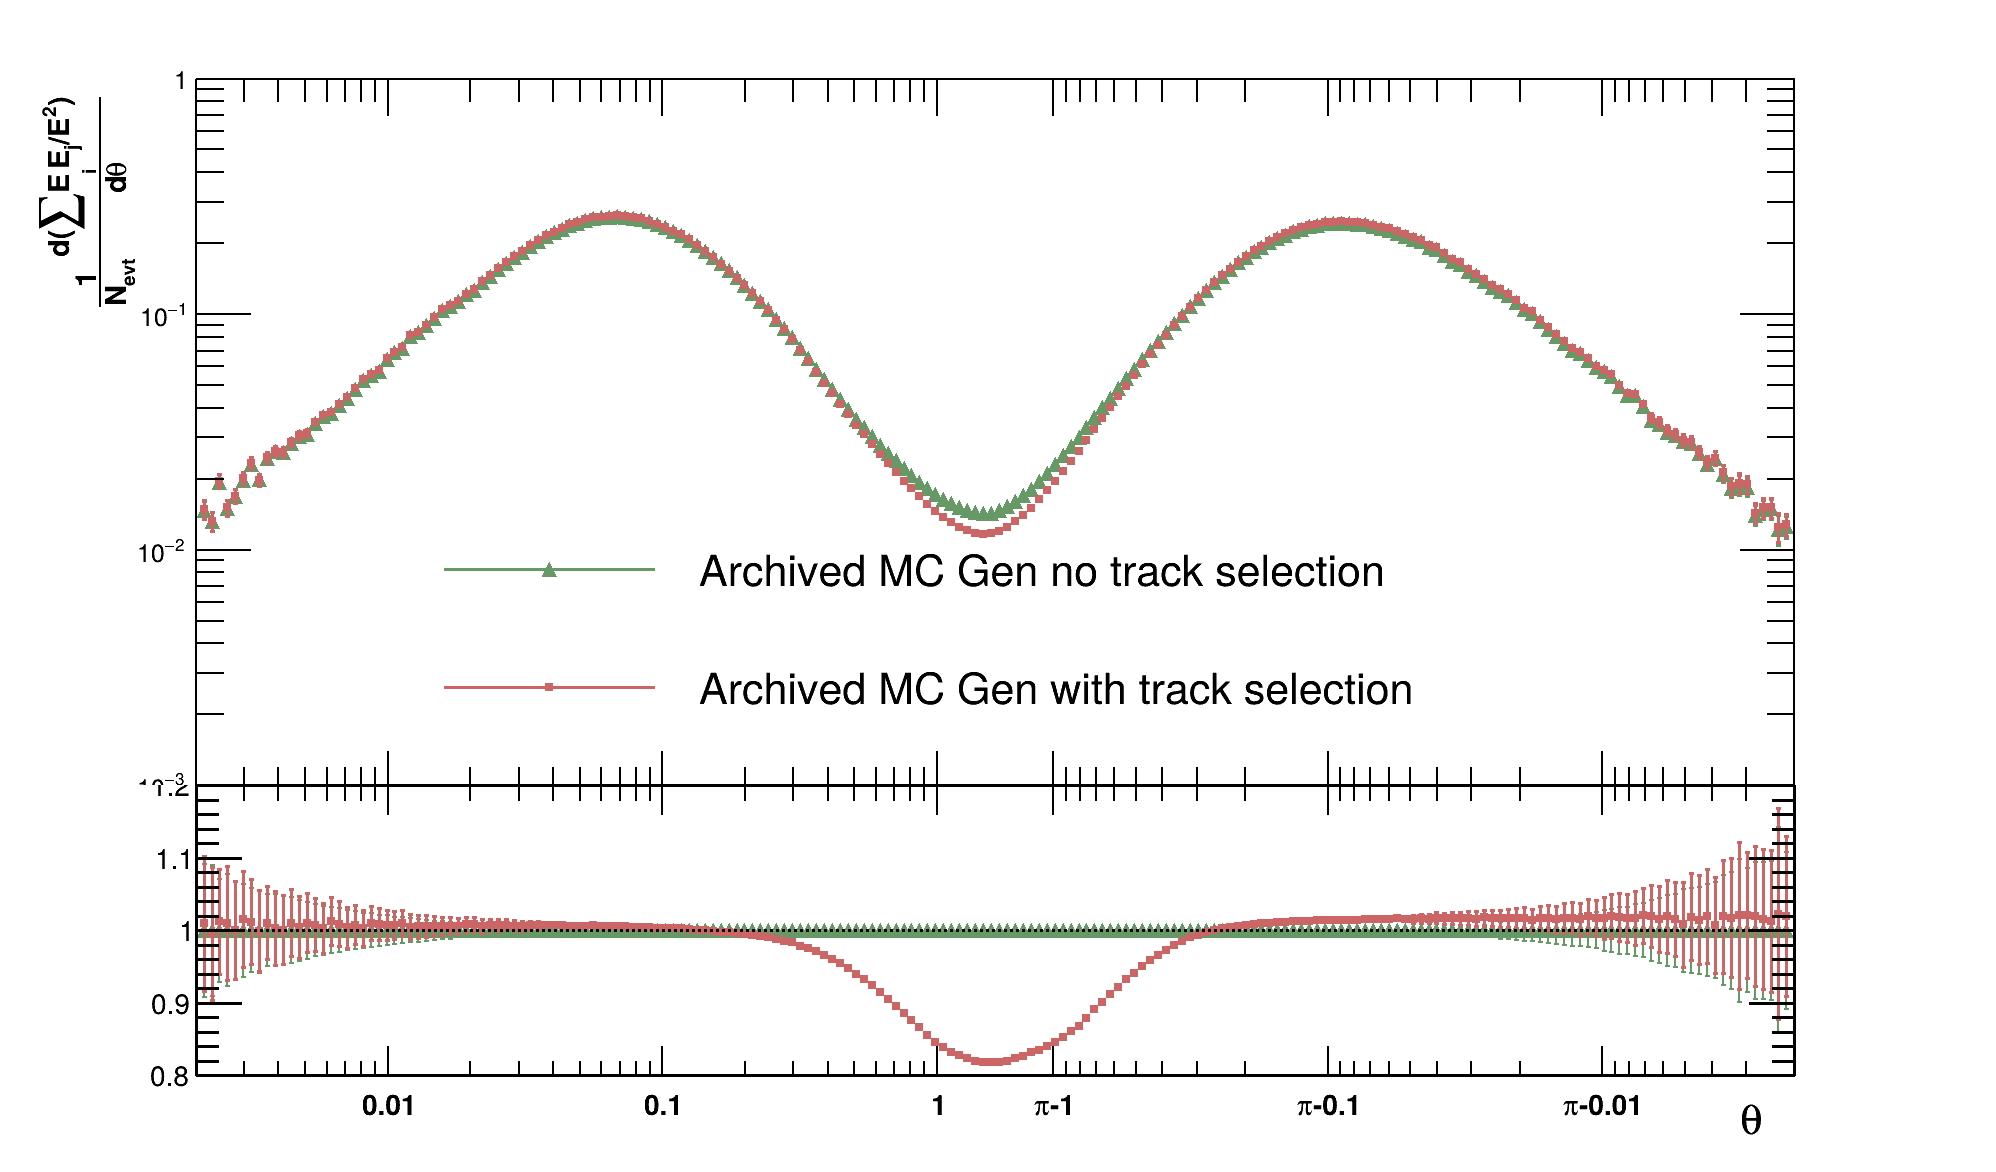

[0.9907316981950257, 1.0038562265970894, 0.9877201339147945, 0.990446446406561, 1.0000739393861544, 0.9847924549759909, 0.9881799298608058, 1.0009188002816416, 0.9898713728454483, 0.9969489569292993, 0.9990333329803232, 0.9896210807969977, 0.9952741899871004, 0.9896051455960068, 0.9925574496170045, 0.9971964678225909, 0.9874175487429492, 0.9908035670060069, 0.9960796040138343, 0.9922684140493796, 0.9965025608627718, 0.9903625547634421, 0.991478362535626, 0.9932215650184116, 0.9922787523891371, 0.9904549420155988, 0.9952748690973227, 0.9942744314455483, 0.9943253505898112, 0.9941519669643794, 0.9938171223831438, 0.9938360384690647, 0.9943003459111269, 0.9918238830719012, 0.9920708853983642, 0.9941688509612671, 0.9928958046808012, 0.9922073590303092, 0.9924315427028912, 0.9936721704964689, 0.9938423981103917, 0.9932785478958174, 0.9930314218619977, 0.9931714447865245, 0.9930868977597834, 0.9932463268445009, 0.993666696557687, 0.993652351259592, 0.9935530242717815, 0.9933086594520957, 0.9

Warning in <TClass::Init>: no dictionary for class RooUnfoldResponse is available
Warning in <TClass::Init>: no dictionary for class RooUnfoldResponseT<TH1,TH2> is available
Info in <TCanvas::Print>: png file EEC_track_sele_cor.png has been created


In [5]:
file1 = ROOT.TFile('hgen_LEP1MC1994_recons_aftercut_noHP.root', 'r')
#file2 = ROOT.TFile('hgen_LEP1MC1994_recons_aftercut.root', 'r')
file2 = ROOT.TFile('response_LEP1MC1994_v14.root', 'r')

hdata1 = file1.Get('EEC_r')
hdata2 = file2.Get('gen1d_eec')
#hdata3 = file.Get('EEC_r_cross')

normalization1 = file1.Get('N').GetBinContent(2)
normalization2 = file2.Get('counter').GetBinContent(2)

hdata1.Scale(1./normalization1)
hdata2.Scale(1./normalization2)

hdata1 = divideBinWidth(hdata1)
hdata2 = divideBinWidth(hdata2)

# --- 4. Create TGraphErrors for Data and Ratios ---

data1_eec = ROOT.TGraphErrors()
data2_eec = ROOT.TGraphErrors()

ratio1   = ROOT.TGraphErrors()
ratio2   = ROOT.TGraphErrors()


# Fill TGraphErrors using the helper function
fill_TGraph(data1_eec, hdata1)
fill_TGraph(data2_eec, hdata2)


corr_trk = []
# Create ratio graphs: here we use hdata1 as a denominator for all ratios.
nb = hdata1.GetNbinsX()
for b in range(nb):
    x_val = hdata1.GetBinCenter(b+1)
    den = hdata1.GetBinContent(b+1) if hdata1.GetBinContent(b+1) != 0 else 1.0  # avoid div-by-zero
    ratio1.SetPoint(b, b+0.5, hdata1.GetBinContent(b+1)/den)
    ratio1.SetPointError(b, 0, hdata1.GetBinError(b+1)/den)
    ratio2.SetPoint(b, b+0.5, hdata2.GetBinContent(b+1)/den)
    ratio2.SetPointError(b, 0, hdata2.GetBinError(b+1)/den)
    corr_trk += [1./(hdata2.GetBinContent(b+1)/den)]

# --- 6. Set Up ROOT Canvas and Style ---

ROOT.gStyle.SetLineWidth(0)
ROOT.gStyle.SetOptStat(0)

xmin, xmax = 0., 200.
ymin, ymax = 0.001, 1.
rymin, rymax = 0.8, 1.2
rylen = rymax - rymin

c4 = ROOT.TCanvas("tmp", "", 0, 0, 2000, 1200)
c4.Divide(1, 2)
pad1 = ROOT.TPad("", "", 0, 0.33, 1, 1)
pad2 = ROOT.TPad("", "", 0, 0, 1, 0.33)
pad1.SetFrameLineWidth(0)
pad2.SetFrameLineWidth(0)
pad1.SetBottomMargin(0.0)
pad2.SetTopMargin(0.0)
pad2.SetBottomMargin(0.25)
pad1.Draw()
pad2.Draw()

# --- 7. Draw Upper Pad (Data) ---

pad1.cd()
pad1.SetLogy()
data1_eec.SetMarkerSize(2)
data1_eec.SetMarkerStyle(22)
data1_eec.SetMarkerColor(ROOT.kGreen-5)
data1_eec.SetLineColor(ROOT.kGreen-5)
data1_eec.SetLineWidth(3)
data1_eec.GetXaxis().SetTickLength(0)
data1_eec.GetXaxis().SetLabelSize(0)
data1_eec.GetXaxis().SetRangeUser(xmin, xmax)
data1_eec.GetYaxis().SetRangeUser(ymin, ymax)
data1_eec.Draw("ap")

data2_eec.SetMarkerSize(1)
data2_eec.SetMarkerStyle(21)
data2_eec.SetMarkerColor(ROOT.kRed-6)
data2_eec.SetLineColor(ROOT.kRed-6)
data2_eec.SetLineWidth(3)
data2_eec.Draw("samep")


# Redraw again to ensure proper layering
data1_eec.Draw("samep")
data2_eec.Draw("samep")


# Draw additional axis and lines
f = ROOT.TF1("f", "log10(x)", ymin, ymax)
newaxis0 = ROOT.TGaxis(p_indices[0], ymin, p_indices[0], ymax, "f", 505, "-G")
newaxis0.SetLabelSize(0)
newaxis0.SetLineWidth(2)
newaxis0.Draw()

newaxis1 = ROOT.TGaxis(xmax - p_indices[0], ymin, xmax - p_indices[0], ymax, "f", 505, "+G")
newaxis1.SetLabelSize(0)
newaxis1.SetLineWidth(2)
newaxis1.Draw()

l0 = ROOT.TLine(xmin, ymax, xmax, ymax)
l0.SetLineWidth(2)
l0.Draw()

l1 = ROOT.TLine(xmin, ymin, xmax, ymin)
l1.SetLineWidth(2)
l1.Draw()

# Draw tick marks based on t_labels and indices
ticks = []
for pos in indices:
    ticks.extend(draw_lines([pos], 0.7*ymax, ymax))
    ticks.extend(draw_lines([pos], ymin, ymin + ymin*0.4))

for pt in p_indices:
    ticks.extend(draw_lines([xmin+pt], 0.8*ymax, ymax))
    ticks.extend(draw_lines([xmax-pt], 0.8*ymax, ymax))
    ticks.extend(draw_lines([xmin+pt], ymin, ymin + ymin*0.2))
    ticks.extend(draw_lines([xmax-pt], ymin, ymin + ymin*0.2))

txt1 = ROOT.TLatex()
txt1.SetTextSize(0.04)
txt1.SetTextAlign(22)
txt1.SetTextAngle(90)
txt1.DrawLatex(-14, 0.3*ymax, "#frac{1}{N_{evt}}#frac{d(#sumE_{i}E_{j}/E^{2})}{d#theta}")

legend = ROOT.TLegend(0.2, 0.05, 0.8, 0.35)
legend.AddEntry(data1_eec, "Archived MC Gen no track selection", "alp")
legend.AddEntry(data2_eec, "Archived MC Gen with track selection", "alp")
legend.SetTextSize(0.06)
legend.SetFillStyle(0)
legend.Draw("same")

# --- 8. Draw Lower Pad (Ratio) ---

pad2.cd()
ratio1.SetLineWidth(2)
ratio1.GetXaxis().SetTickLength(0)
ratio1.GetXaxis().SetLabelSize(0)
ratio1.GetXaxis().SetRangeUser(xmin, xmax)
ratio1.SetMarkerSize(2)
ratio1.SetMarkerStyle(22)
ratio1.SetMarkerColor(ROOT.kGreen-5)
ratio1.SetLineColor(ROOT.kGreen-5)
ratio1.Draw("ap")
ratio1.GetYaxis().SetRangeUser(rymin, rymax)
ratio1.GetYaxis().SetNdivisions(505)
ratio1.GetYaxis().SetLabelSize(0.08)

ratio2.SetMarkerSize(1)
ratio2.SetMarkerStyle(21)
ratio2.SetMarkerColor(ROOT.kRed-6)
ratio2.SetLineColor(ROOT.kRed-6)
ratio2.SetLineWidth(3)
ratio2.Draw("samep")


# Draw tick labels along x-axis
for pos, lab in zip(indices, t_labels):
    tex = ROOT.TLatex()
    tex.SetTextSize(0.08)
    tex.SetTextAlign(22)
    tex.DrawLatex(pos, rymin - 0.1*rylen, lab)
    tick = ROOT.TLine(pos, rymin, pos, rymin + rylen*0.1)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks.append(tick)

for pos in indices:
    tick = ROOT.TLine(pos, rymax - rylen*0.1, pos, rymax)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks.append(tick)

for pt in p_indices:
    ticks.extend(draw_lines([xmin+pt], rymin, rymin+rylen*0.05))
    ticks.extend(draw_lines([xmax-pt], rymin, rymin+rylen*0.05))
    ticks.extend(draw_lines([xmin+pt], rymax-rylen*0.05, rymax))
    ticks.extend(draw_lines([xmax-pt], rymax-rylen*0.05, rymax))

newaxis2 = ROOT.TGaxis(p_indices[0], rymin, p_indices[0], rymax, rymin, rymax, 505, "-L")
newaxis2.SetLabelSize(0)
newaxis2.SetLineWidth(3)
newaxis2.Draw()

newaxis3 = ROOT.TGaxis(xmax-p_indices[0], rymin, xmax-p_indices[0], rymax, rymin, rymax, 505, "+L")
newaxis3.SetLabelSize(0)
newaxis3.SetLineWidth(3)
newaxis3.Draw()

l2 = ROOT.TLine(0, rymax, 200, rymax)
l2.SetLineWidth(3)
l2.Draw()

l3 = ROOT.TLine(0, rymin, 200, rymin)
l3.SetLineWidth(3)
l3.Draw()

l4 = ROOT.TLine(0,1,200,1)
l4.SetLineWidth(3)
l4.SetLineStyle(2)
l4.Draw()

txt2 = ROOT.TLatex()
txt2.SetTextSize(0.12)
txt2.SetTextAlign(22)
txt2.DrawLatex(195, rymin - 0.15*rylen, "#theta")

c4.SaveAs('EEC_track_sele_cor.png')
c4.Close()
clear_output(wait=True)
display(Image("EEC_track_sele_cor.png"))

print(corr_trk)

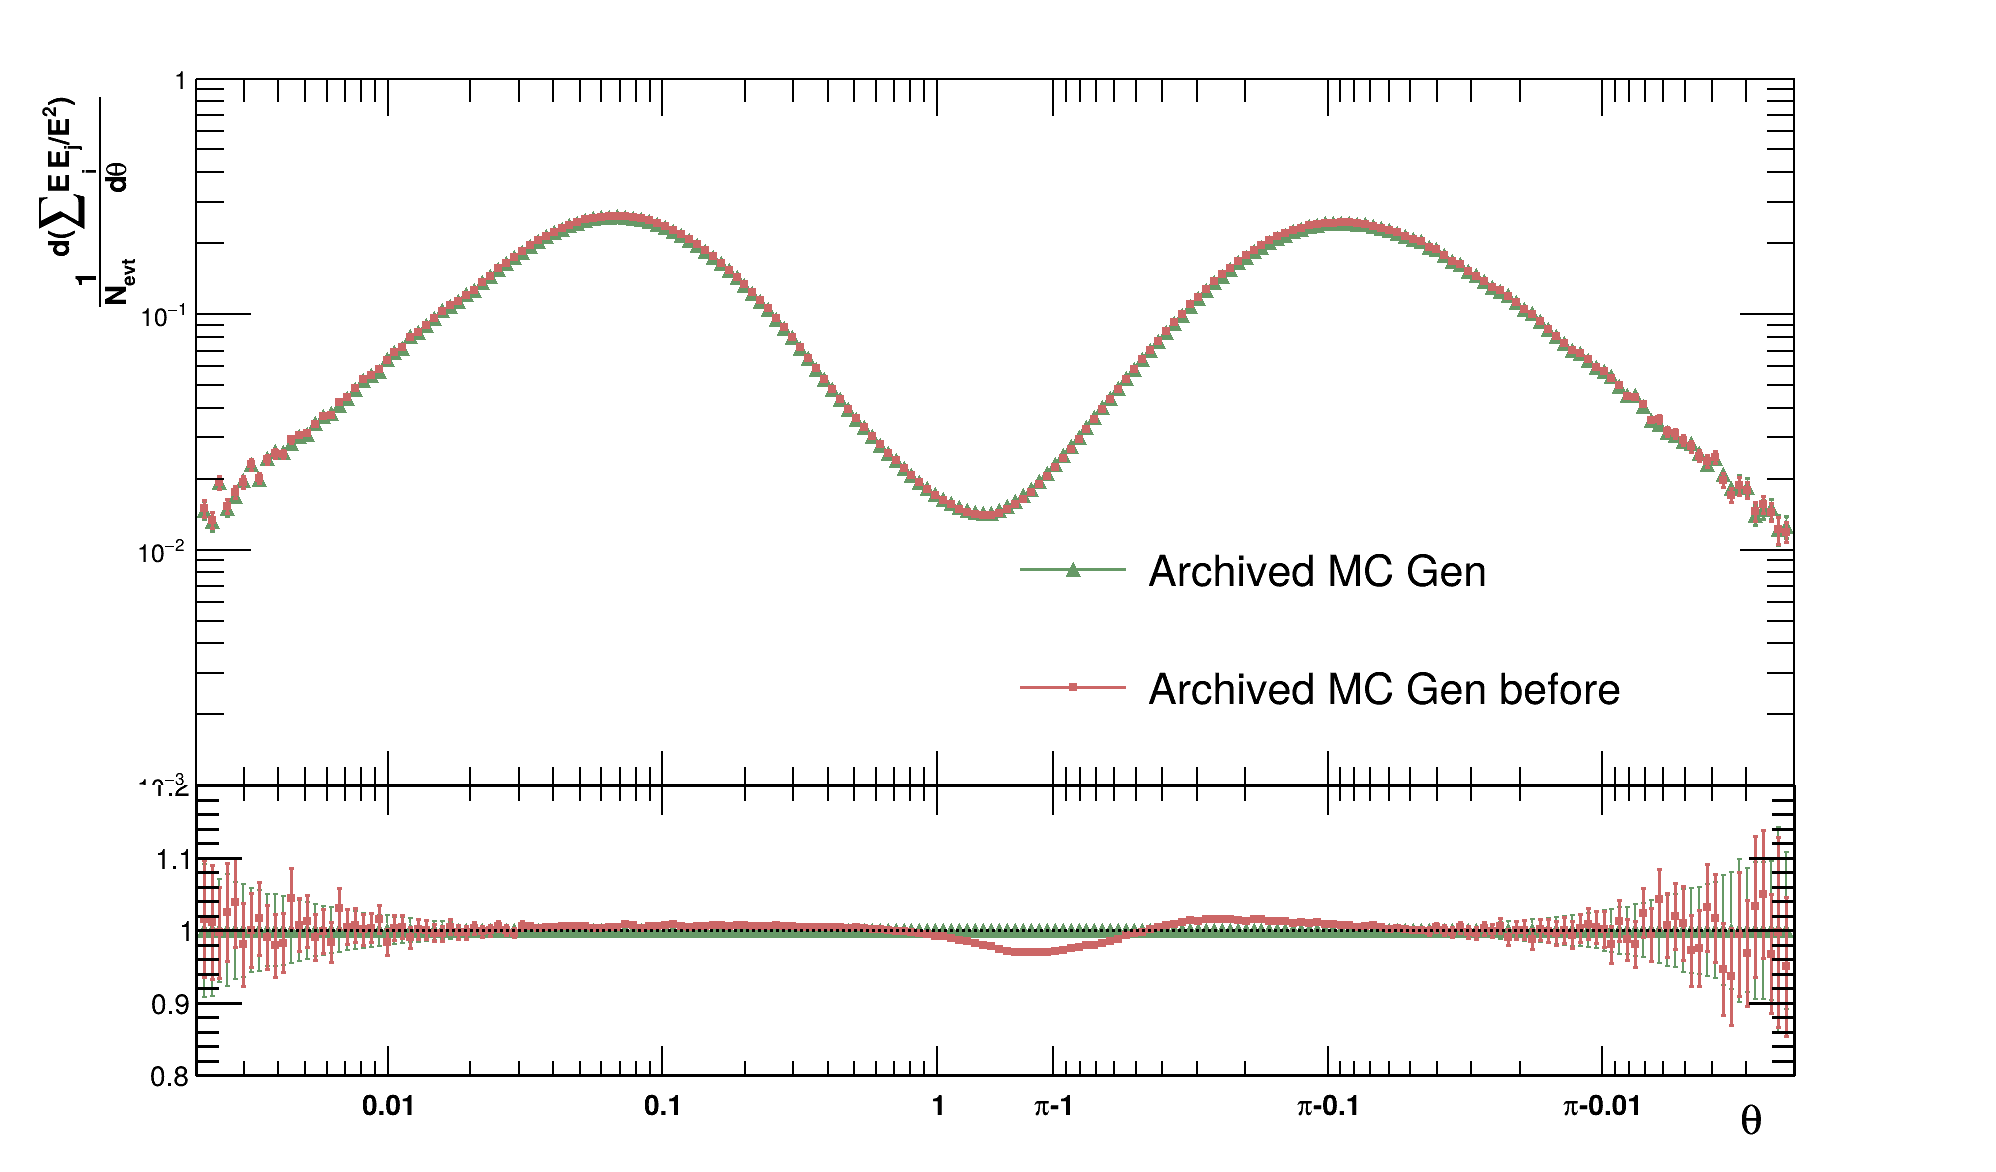

[1.0158507772533634, 1.011441694698784, 0.9971759199655396, 1.025365223240077, 1.0383422471594594, 0.9806605255905382, 1.0001424275433901, 1.0164789024529572, 0.9906346983998148, 0.9791564800940246, 0.9825992525797502, 1.0451017501105113, 1.0078833907610498, 1.0131500287123194, 0.9908205064509569, 0.9989590403831186, 0.9840808293570126, 1.0300471848615946, 1.0049984607400606, 1.0075026889968834, 1.0011320015154002, 1.0038122851957814, 1.0158652525350982, 0.9839027081751965, 1.0037472516997752, 1.0046758077459328, 0.9900840653586228, 1.0016822400379393, 1.000814181639781, 0.9966980445504038, 0.9955645972897071, 1.0048098098544633, 0.9973387776056453, 0.9972577661914671, 1.0033346660903928, 0.9985339606291379, 1.0001691482426511, 1.005572380619206, 1.0002705388667175, 0.9967995246909009, 1.0063600472396392, 1.0062765800558544, 1.0030635707731914, 1.0038308813087624, 1.0038883680797646, 1.0062036269250902, 1.0059401425504582, 1.0056645890580471, 1.006282337553259, 1.003691283170018, 1.003

Info in <TCanvas::Print>: png file EEC_evt_sele_cor.png has been created


In [6]:
file1 = ROOT.TFile('hgen_LEP1MC1994_recons_aftercut_noHP.root', 'r')
file2 = ROOT.TFile('hgenBefore_LEP1MC1994_recons_aftercut.root', 'r')

hdata1 = file1.Get('EEC_r')
hdata2 = file2.Get('EEC_r')
#hdata3 = file.Get('EEC_r_cross')

normalization1 = file1.Get('N').GetBinContent(2)
normalization2 = file2.Get('N').GetBinContent(2)

hdata1.Scale(1./normalization1)
hdata2.Scale(1./normalization2)

hdata1 = divideBinWidth(hdata1)
hdata2 = divideBinWidth(hdata2)

# --- 4. Create TGraphErrors for Data and Ratios ---

data1_eec = ROOT.TGraphErrors()
data2_eec = ROOT.TGraphErrors()

ratio1   = ROOT.TGraphErrors()
ratio2   = ROOT.TGraphErrors()


# Fill TGraphErrors using the helper function
fill_TGraph(data1_eec, hdata1)
fill_TGraph(data2_eec, hdata2)

corr_evt=[]
# Create ratio graphs: here we use hdata1 as a denominator for all ratios.
nb = hdata1.GetNbinsX()
for b in range(nb):
    x_val = hdata1.GetBinCenter(b+1)
    den = hdata1.GetBinContent(b+1) if hdata1.GetBinContent(b+1) != 0 else 1.0  # avoid div-by-zero
    ratio1.SetPoint(b, b+0.5, hdata1.GetBinContent(b+1)/den)
    ratio1.SetPointError(b, 0, hdata1.GetBinError(b+1)/den)
    ratio2.SetPoint(b, b+0.5, hdata2.GetBinContent(b+1)/den)
    ratio2.SetPointError(b, 0, hdata2.GetBinError(b+1)/den)
    corr_evt+=[hdata2.GetBinContent(b+1)/den]

# --- 6. Set Up ROOT Canvas and Style ---

ROOT.gStyle.SetLineWidth(0)
ROOT.gStyle.SetOptStat(0)

xmin, xmax = 0., 200.
ymin, ymax = 0.001, 1.
rymin, rymax = 0.8, 1.2
rylen = rymax - rymin

c4 = ROOT.TCanvas("tmp", "", 0, 0, 2000, 1200)
c4.Divide(1, 2)
pad1 = ROOT.TPad("", "", 0, 0.33, 1, 1)
pad2 = ROOT.TPad("", "", 0, 0, 1, 0.33)
pad1.SetFrameLineWidth(0)
pad2.SetFrameLineWidth(0)
pad1.SetBottomMargin(0.0)
pad2.SetTopMargin(0.0)
pad2.SetBottomMargin(0.25)
pad1.Draw()
pad2.Draw()

# --- 7. Draw Upper Pad (Data) ---

pad1.cd()
pad1.SetLogy()
data1_eec.SetMarkerSize(2)
data1_eec.SetMarkerStyle(22)
data1_eec.SetMarkerColor(ROOT.kGreen-5)
data1_eec.SetLineColor(ROOT.kGreen-5)
data1_eec.SetLineWidth(3)
data1_eec.GetXaxis().SetTickLength(0)
data1_eec.GetXaxis().SetLabelSize(0)
data1_eec.GetXaxis().SetRangeUser(xmin, xmax)
data1_eec.GetYaxis().SetRangeUser(ymin, ymax)
data1_eec.Draw("ap")

data2_eec.SetMarkerSize(1)
data2_eec.SetMarkerStyle(21)
data2_eec.SetMarkerColor(ROOT.kRed-6)
data2_eec.SetLineColor(ROOT.kRed-6)
data2_eec.SetLineWidth(3)
data2_eec.Draw("samep")


# Redraw again to ensure proper layering
data1_eec.Draw("samep")
data2_eec.Draw("samep")


# Draw additional axis and lines
f = ROOT.TF1("f", "log10(x)", ymin, ymax)
newaxis0 = ROOT.TGaxis(p_indices[0], ymin, p_indices[0], ymax, "f", 505, "-G")
newaxis0.SetLabelSize(0)
newaxis0.SetLineWidth(2)
newaxis0.Draw()

newaxis1 = ROOT.TGaxis(xmax - p_indices[0], ymin, xmax - p_indices[0], ymax, "f", 505, "+G")
newaxis1.SetLabelSize(0)
newaxis1.SetLineWidth(2)
newaxis1.Draw()

l0 = ROOT.TLine(xmin, ymax, xmax, ymax)
l0.SetLineWidth(2)
l0.Draw()

l1 = ROOT.TLine(xmin, ymin, xmax, ymin)
l1.SetLineWidth(2)
l1.Draw()

# Draw tick marks based on t_labels and indices
ticks = []
for pos in indices:
    ticks.extend(draw_lines([pos], 0.7*ymax, ymax))
    ticks.extend(draw_lines([pos], ymin, ymin + ymin*0.4))

for pt in p_indices:
    ticks.extend(draw_lines([xmin+pt], 0.8*ymax, ymax))
    ticks.extend(draw_lines([xmax-pt], 0.8*ymax, ymax))
    ticks.extend(draw_lines([xmin+pt], ymin, ymin + ymin*0.2))
    ticks.extend(draw_lines([xmax-pt], ymin, ymin + ymin*0.2))

txt1 = ROOT.TLatex()
txt1.SetTextSize(0.04)
txt1.SetTextAlign(22)
txt1.SetTextAngle(90)
txt1.DrawLatex(-14, 0.3*ymax, "#frac{1}{N_{evt}}#frac{d(#sumE_{i}E_{j}/E^{2})}{d#theta}")

legend = ROOT.TLegend(0.5, 0.05, 0.8, 0.35)
legend.AddEntry(data1_eec, "Archived MC Gen", "alp")
legend.AddEntry(data2_eec, "Archived MC Gen before", "alp")
legend.SetTextSize(0.06)
legend.SetFillStyle(0)
legend.Draw("same")

# --- 8. Draw Lower Pad (Ratio) ---

pad2.cd()
ratio1.SetLineWidth(2)
ratio1.GetXaxis().SetTickLength(0)
ratio1.GetXaxis().SetLabelSize(0)
ratio1.GetXaxis().SetRangeUser(xmin, xmax)
ratio1.SetMarkerSize(2)
ratio1.SetMarkerStyle(22)
ratio1.SetMarkerColor(ROOT.kGreen-5)
ratio1.SetLineColor(ROOT.kGreen-5)
ratio1.Draw("ap")
ratio1.GetYaxis().SetRangeUser(rymin, rymax)
ratio1.GetYaxis().SetNdivisions(505)
ratio1.GetYaxis().SetLabelSize(0.08)

ratio2.SetMarkerSize(1)
ratio2.SetMarkerStyle(21)
ratio2.SetMarkerColor(ROOT.kRed-6)
ratio2.SetLineColor(ROOT.kRed-6)
ratio2.SetLineWidth(3)
ratio2.Draw("samep")


# Draw tick labels along x-axis
for pos, lab in zip(indices, t_labels):
    tex = ROOT.TLatex()
    tex.SetTextSize(0.08)
    tex.SetTextAlign(22)
    tex.DrawLatex(pos, rymin - 0.1*rylen, lab)
    tick = ROOT.TLine(pos, rymin, pos, rymin + rylen*0.1)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks.append(tick)

for pos in indices:
    tick = ROOT.TLine(pos, rymax - rylen*0.1, pos, rymax)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks.append(tick)

for pt in p_indices:
    ticks.extend(draw_lines([xmin+pt], rymin, rymin+rylen*0.05))
    ticks.extend(draw_lines([xmax-pt], rymin, rymin+rylen*0.05))
    ticks.extend(draw_lines([xmin+pt], rymax-rylen*0.05, rymax))
    ticks.extend(draw_lines([xmax-pt], rymax-rylen*0.05, rymax))

newaxis2 = ROOT.TGaxis(p_indices[0], rymin, p_indices[0], rymax, rymin, rymax, 505, "-L")
newaxis2.SetLabelSize(0)
newaxis2.SetLineWidth(3)
newaxis2.Draw()

newaxis3 = ROOT.TGaxis(xmax-p_indices[0], rymin, xmax-p_indices[0], rymax, rymin, rymax, 505, "+L")
newaxis3.SetLabelSize(0)
newaxis3.SetLineWidth(3)
newaxis3.Draw()

l2 = ROOT.TLine(0, rymax, 200, rymax)
l2.SetLineWidth(3)
l2.Draw()

l3 = ROOT.TLine(0, rymin, 200, rymin)
l3.SetLineWidth(3)
l3.Draw()

l4 = ROOT.TLine(0,1,200,1)
l4.SetLineWidth(3)
l4.SetLineStyle(2)
l4.Draw()

txt2 = ROOT.TLatex()
txt2.SetTextSize(0.12)
txt2.SetTextAlign(22)
txt2.DrawLatex(195, rymin - 0.15*rylen, "#theta")

c4.SaveAs('EEC_evt_sele_cor.png')
c4.Close()
clear_output(wait=True)
display(Image("EEC_evt_sele_cor.png"))
print(corr_evt)

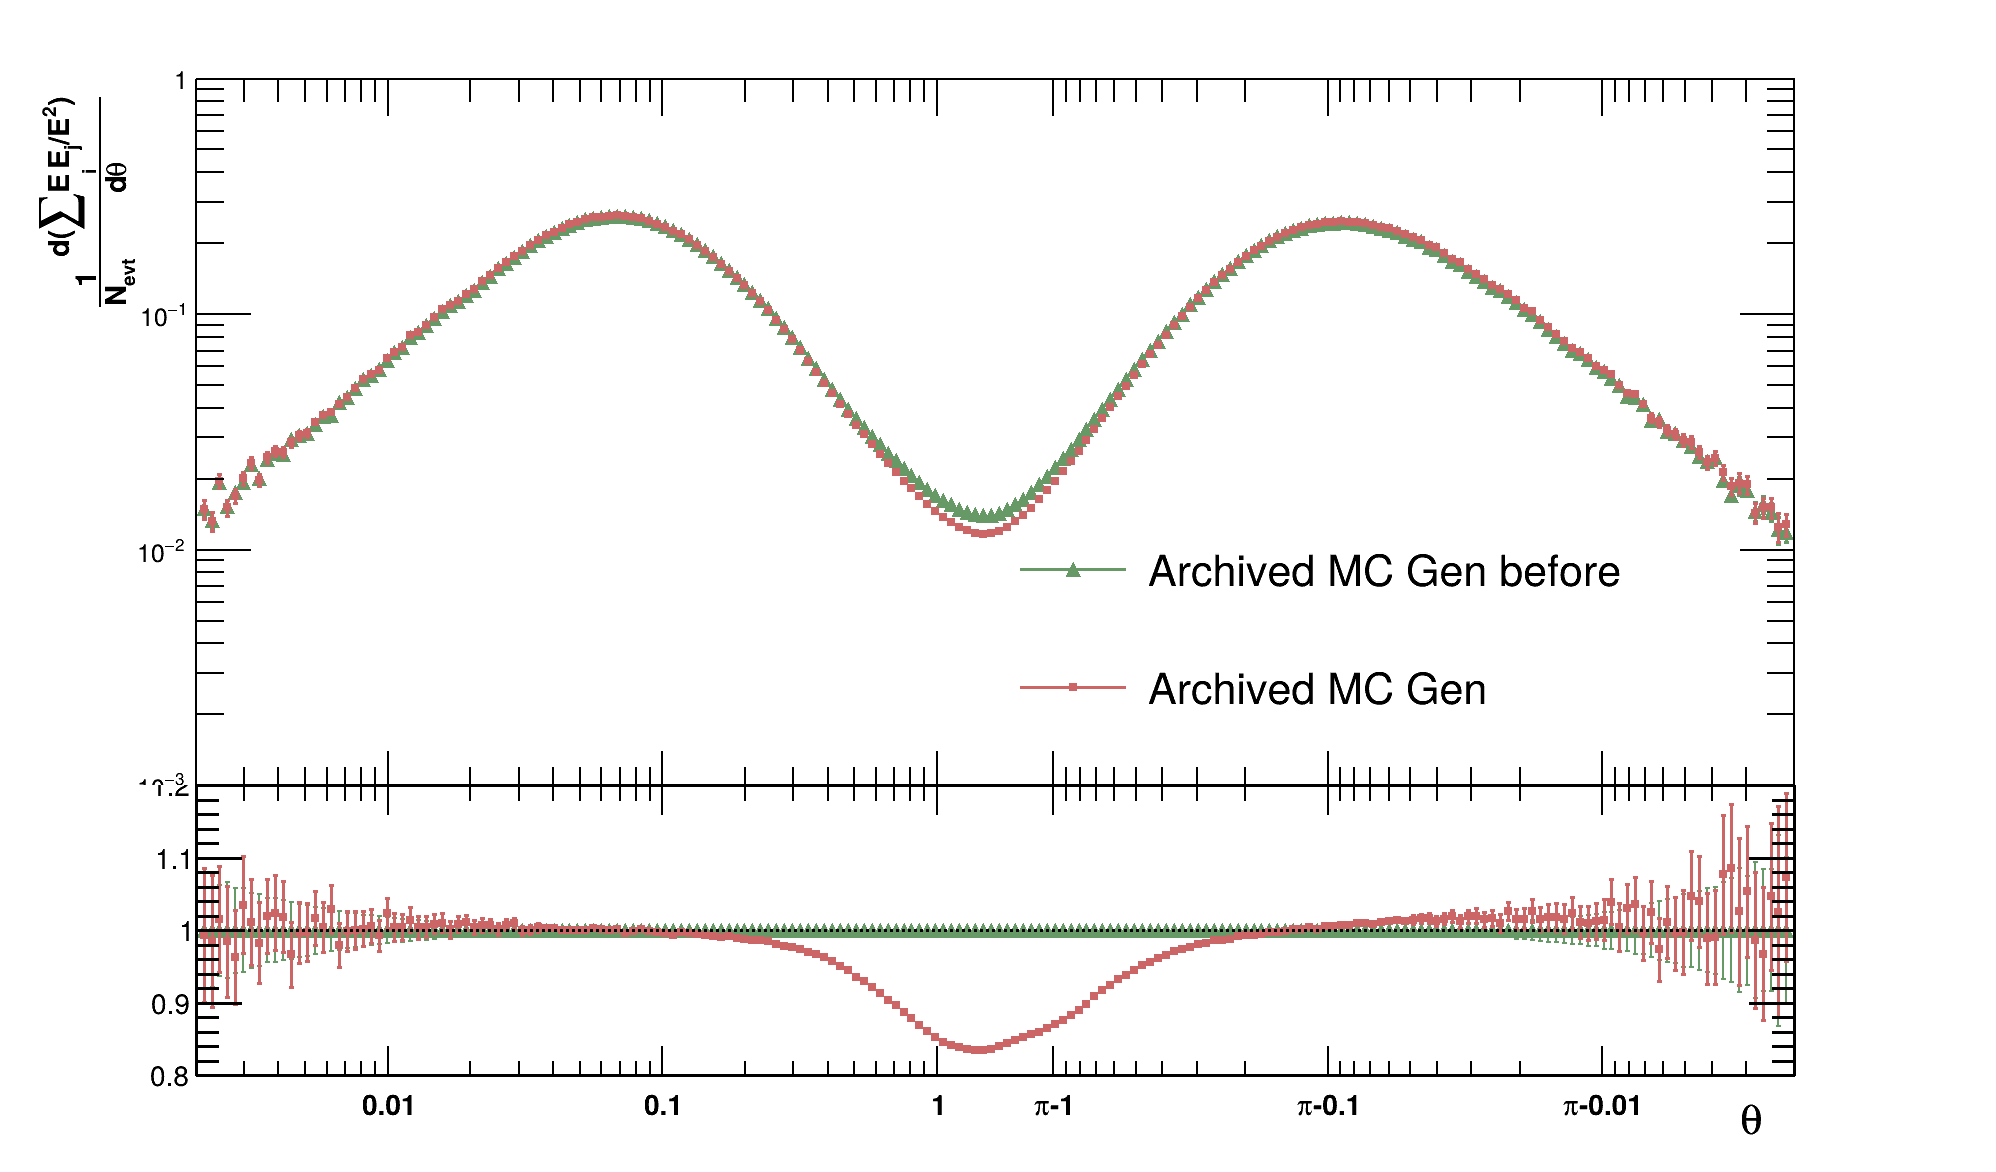

[1.0064355656609616, 1.0153420430632867, 0.9849307332049712, 1.0155693416270044, 1.0384190215478326, 0.9657470864943516, 0.988320673900643, 1.0174128435548138, 0.9806009288933613, 0.976169031500302, 0.9816494062887222, 1.034254723487198, 1.0031203253411562, 1.0026184816744532, 0.9834462749111905, 0.9961584265694907, 0.9716986802886297, 1.0205744249453637, 1.0010584688084725, 0.9997130953614228, 0.9976306032717686, 0.9941380992694231, 1.0072084171403393, 0.9772333876396223, 0.9959970706306779, 0.9950861189054728, 0.9854057885451484, 0.9959470397028249, 0.9951349120342304, 0.9908693214593345, 0.9894091432249901, 0.9986162008406141, 0.9916542915638735, 0.9891040700876311, 0.9953791105391683, 0.992711360284473, 0.9930637512612984, 0.9977363160880035, 0.9927000340077488, 0.990491947249456, 1.0001632827111302, 0.9995129402194484, 0.996073643902875, 0.9969761667107537, 0.9969483851534652, 0.9994080565009604, 0.9995692183828825, 0.9992809834960399, 0.9997948597473181, 0.9969752429893642, 0.997

Info in <TCanvas::Print>: png file EEC_evt_sele_cor2.png has been created


In [7]:
#file1 = ROOT.TFile('hgen_LEP1MC1994_recons_aftercut.root', 'r')
file1 = ROOT.TFile('hgenBefore_LEP1MC1994_recons_aftercut.root', 'r')
file2 = ROOT.TFile('response_LEP1MC1994_v14.root', 'r')

hdata1 = file1.Get('EEC_r')
hdata2 = file2.Get('gen1d_eec')
#hdata3 = file.Get('EEC_r_cross')

normalization1 = file1.Get('N').GetBinContent(2)
normalization2 = file2.Get('counter').GetBinContent(2)

hdata1.Scale(1./normalization1)
hdata2.Scale(1./normalization2)

hdata1 = divideBinWidth(hdata1)
hdata2 = divideBinWidth(hdata2)

# --- 4. Create TGraphErrors for Data and Ratios ---

data1_eec = ROOT.TGraphErrors()
data2_eec = ROOT.TGraphErrors()

ratio1   = ROOT.TGraphErrors()
ratio2   = ROOT.TGraphErrors()


# Fill TGraphErrors using the helper function
fill_TGraph(data1_eec, hdata1)
fill_TGraph(data2_eec, hdata2)

corr_evt2=[]
# Create ratio graphs: here we use hdata1 as a denominator for all ratios.
nb = hdata1.GetNbinsX()
for b in range(nb):
    x_val = hdata1.GetBinCenter(b+1)
    den = hdata1.GetBinContent(b+1) if hdata1.GetBinContent(b+1) != 0 else 1.0  # avoid div-by-zero
    ratio1.SetPoint(b, b+0.5, hdata1.GetBinContent(b+1)/den)
    ratio1.SetPointError(b, 0, hdata1.GetBinError(b+1)/den)
    ratio2.SetPoint(b, b+0.5, hdata2.GetBinContent(b+1)/den)
    ratio2.SetPointError(b, 0, hdata2.GetBinError(b+1)/den)
    corr_evt2+=[1./(hdata2.GetBinContent(b+1)/den)]

# --- 6. Set Up ROOT Canvas and Style ---

ROOT.gStyle.SetLineWidth(0)
ROOT.gStyle.SetOptStat(0)

xmin, xmax = 0., 200.
ymin, ymax = 0.001, 1.
rymin, rymax = 0.8, 1.2
rylen = rymax - rymin

c4 = ROOT.TCanvas("tmp", "", 0, 0, 2000, 1200)
c4.Divide(1, 2)
pad1 = ROOT.TPad("", "", 0, 0.33, 1, 1)
pad2 = ROOT.TPad("", "", 0, 0, 1, 0.33)
pad1.SetFrameLineWidth(0)
pad2.SetFrameLineWidth(0)
pad1.SetBottomMargin(0.0)
pad2.SetTopMargin(0.0)
pad2.SetBottomMargin(0.25)
pad1.Draw()
pad2.Draw()

# --- 7. Draw Upper Pad (Data) ---

pad1.cd()
pad1.SetLogy()
data1_eec.SetMarkerSize(2)
data1_eec.SetMarkerStyle(22)
data1_eec.SetMarkerColor(ROOT.kGreen-5)
data1_eec.SetLineColor(ROOT.kGreen-5)
data1_eec.SetLineWidth(3)
data1_eec.GetXaxis().SetTickLength(0)
data1_eec.GetXaxis().SetLabelSize(0)
data1_eec.GetXaxis().SetRangeUser(xmin, xmax)
data1_eec.GetYaxis().SetRangeUser(ymin, ymax)
data1_eec.Draw("ap")

data2_eec.SetMarkerSize(1)
data2_eec.SetMarkerStyle(21)
data2_eec.SetMarkerColor(ROOT.kRed-6)
data2_eec.SetLineColor(ROOT.kRed-6)
data2_eec.SetLineWidth(3)
data2_eec.Draw("samep")


# Redraw again to ensure proper layering
data1_eec.Draw("samep")
data2_eec.Draw("samep")


# Draw additional axis and lines
f = ROOT.TF1("f", "log10(x)", ymin, ymax)
newaxis0 = ROOT.TGaxis(p_indices[0], ymin, p_indices[0], ymax, "f", 505, "-G")
newaxis0.SetLabelSize(0)
newaxis0.SetLineWidth(2)
newaxis0.Draw()

newaxis1 = ROOT.TGaxis(xmax - p_indices[0], ymin, xmax - p_indices[0], ymax, "f", 505, "+G")
newaxis1.SetLabelSize(0)
newaxis1.SetLineWidth(2)
newaxis1.Draw()

l0 = ROOT.TLine(xmin, ymax, xmax, ymax)
l0.SetLineWidth(2)
l0.Draw()

l1 = ROOT.TLine(xmin, ymin, xmax, ymin)
l1.SetLineWidth(2)
l1.Draw()

# Draw tick marks based on t_labels and indices
ticks = []
for pos in indices:
    ticks.extend(draw_lines([pos], 0.7*ymax, ymax))
    ticks.extend(draw_lines([pos], ymin, ymin + ymin*0.4))

for pt in p_indices:
    ticks.extend(draw_lines([xmin+pt], 0.8*ymax, ymax))
    ticks.extend(draw_lines([xmax-pt], 0.8*ymax, ymax))
    ticks.extend(draw_lines([xmin+pt], ymin, ymin + ymin*0.2))
    ticks.extend(draw_lines([xmax-pt], ymin, ymin + ymin*0.2))

txt1 = ROOT.TLatex()
txt1.SetTextSize(0.04)
txt1.SetTextAlign(22)
txt1.SetTextAngle(90)
txt1.DrawLatex(-14, 0.3*ymax, "#frac{1}{N_{evt}}#frac{d(#sumE_{i}E_{j}/E^{2})}{d#theta}")

legend = ROOT.TLegend(0.5, 0.05, 0.8, 0.35)
legend.AddEntry(data1_eec, "Archived MC Gen before", "alp")
legend.AddEntry(data2_eec, "Archived MC Gen", "alp")
legend.SetTextSize(0.06)
legend.SetFillStyle(0)
legend.Draw("same")

# --- 8. Draw Lower Pad (Ratio) ---

pad2.cd()
ratio1.SetLineWidth(2)
ratio1.GetXaxis().SetTickLength(0)
ratio1.GetXaxis().SetLabelSize(0)
ratio1.GetXaxis().SetRangeUser(xmin, xmax)
ratio1.SetMarkerSize(2)
ratio1.SetMarkerStyle(22)
ratio1.SetMarkerColor(ROOT.kGreen-5)
ratio1.SetLineColor(ROOT.kGreen-5)
ratio1.Draw("ap")
ratio1.GetYaxis().SetRangeUser(rymin, rymax)
ratio1.GetYaxis().SetNdivisions(505)
ratio1.GetYaxis().SetLabelSize(0.08)

ratio2.SetMarkerSize(1)
ratio2.SetMarkerStyle(21)
ratio2.SetMarkerColor(ROOT.kRed-6)
ratio2.SetLineColor(ROOT.kRed-6)
ratio2.SetLineWidth(3)
ratio2.Draw("samep")


# Draw tick labels along x-axis
for pos, lab in zip(indices, t_labels):
    tex = ROOT.TLatex()
    tex.SetTextSize(0.08)
    tex.SetTextAlign(22)
    tex.DrawLatex(pos, rymin - 0.1*rylen, lab)
    tick = ROOT.TLine(pos, rymin, pos, rymin + rylen*0.1)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks.append(tick)

for pos in indices:
    tick = ROOT.TLine(pos, rymax - rylen*0.1, pos, rymax)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks.append(tick)

for pt in p_indices:
    ticks.extend(draw_lines([xmin+pt], rymin, rymin+rylen*0.05))
    ticks.extend(draw_lines([xmax-pt], rymin, rymin+rylen*0.05))
    ticks.extend(draw_lines([xmin+pt], rymax-rylen*0.05, rymax))
    ticks.extend(draw_lines([xmax-pt], rymax-rylen*0.05, rymax))

newaxis2 = ROOT.TGaxis(p_indices[0], rymin, p_indices[0], rymax, rymin, rymax, 505, "-L")
newaxis2.SetLabelSize(0)
newaxis2.SetLineWidth(3)
newaxis2.Draw()

newaxis3 = ROOT.TGaxis(xmax-p_indices[0], rymin, xmax-p_indices[0], rymax, rymin, rymax, 505, "+L")
newaxis3.SetLabelSize(0)
newaxis3.SetLineWidth(3)
newaxis3.Draw()

l2 = ROOT.TLine(0, rymax, 200, rymax)
l2.SetLineWidth(3)
l2.Draw()

l3 = ROOT.TLine(0, rymin, 200, rymin)
l3.SetLineWidth(3)
l3.Draw()

l4 = ROOT.TLine(0,1,200,1)
l4.SetLineWidth(3)
l4.SetLineStyle(2)
l4.Draw()

txt2 = ROOT.TLatex()
txt2.SetTextSize(0.12)
txt2.SetTextAlign(22)
txt2.DrawLatex(195, rymin - 0.15*rylen, "#theta")

c4.SaveAs('EEC_evt_sele_cor2.png')
c4.Close()
clear_output(wait=True)
display(Image("EEC_evt_sele_cor2.png"))
print(corr_evt2)

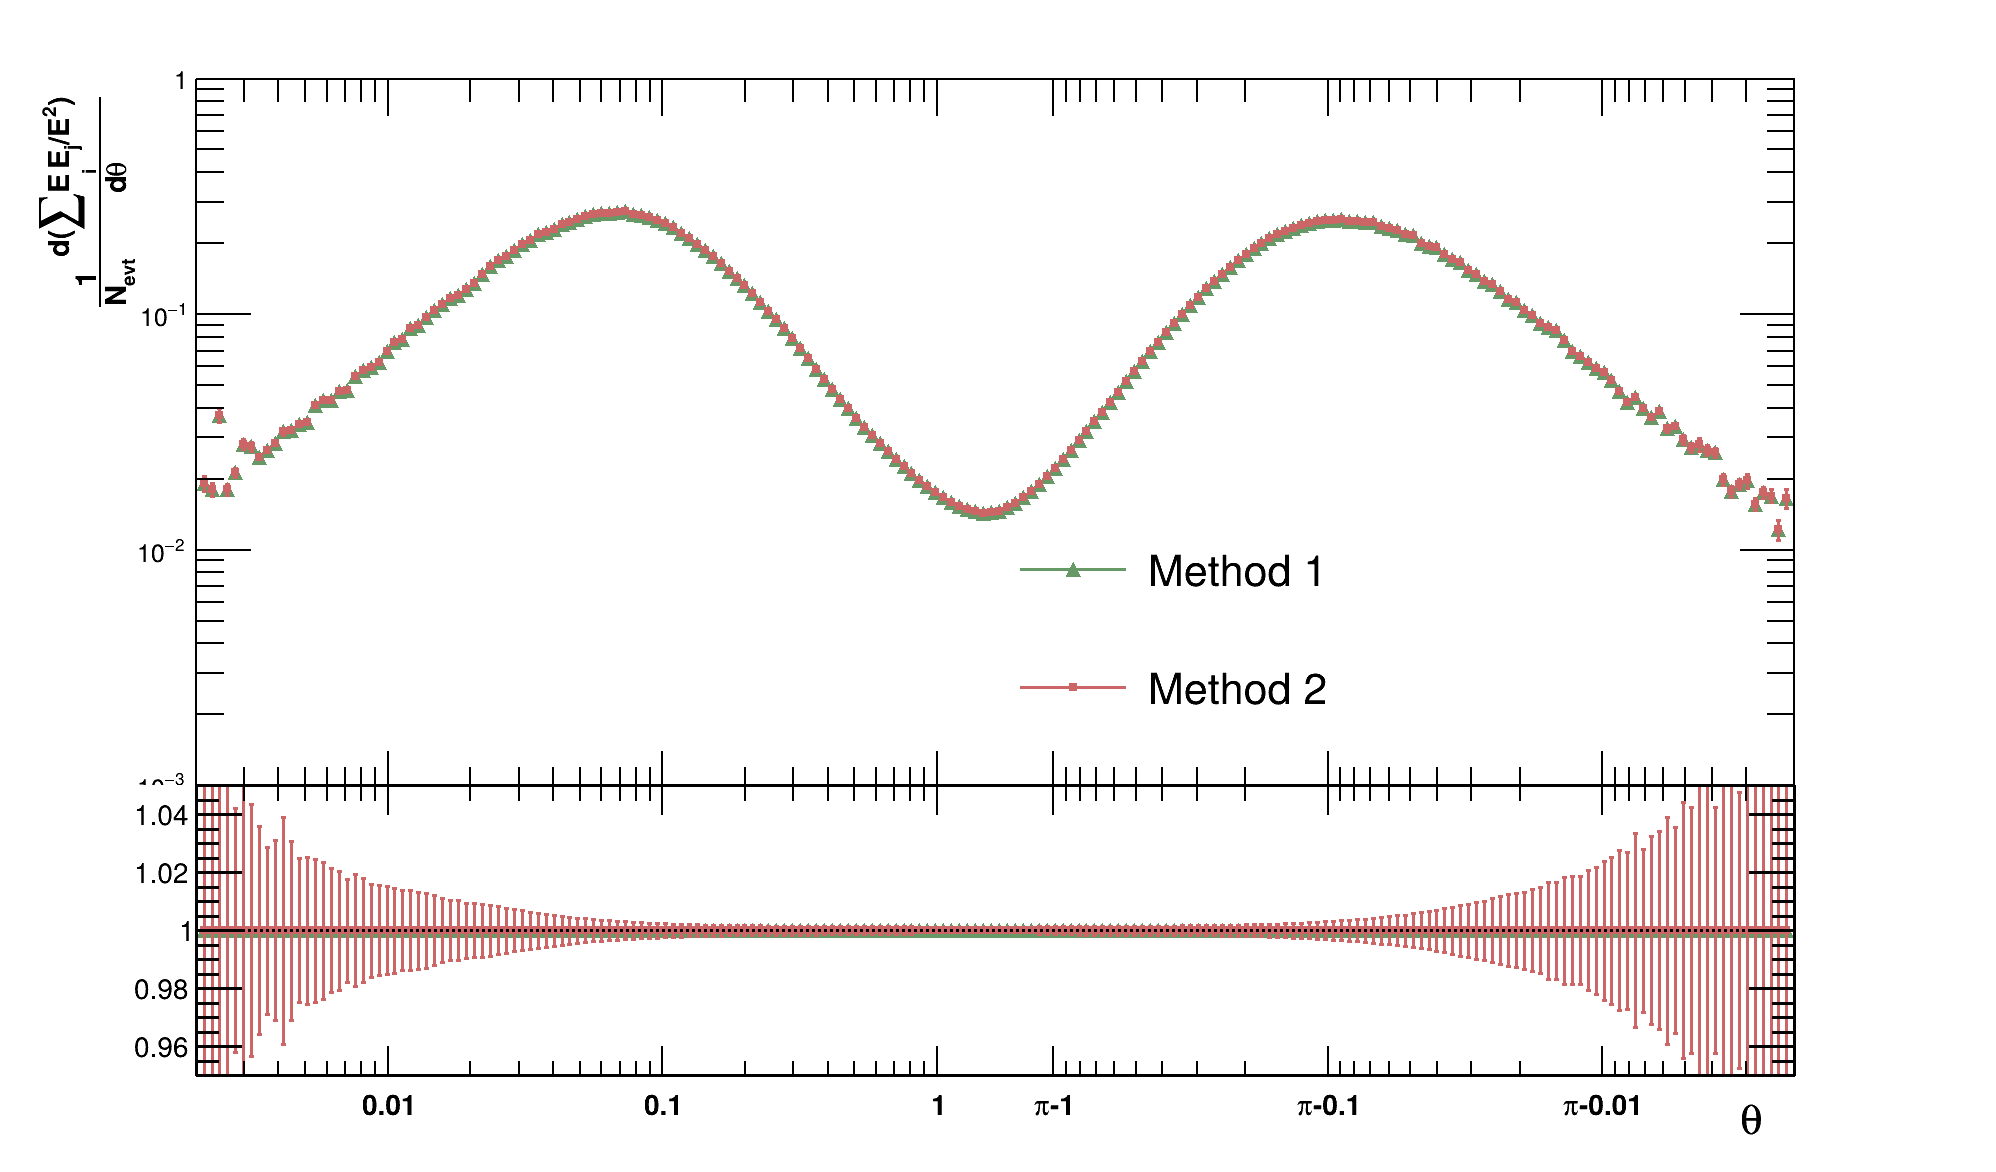

Info in <TCanvas::Print>: png file EEC_cor_comp.png has been created


In [8]:
unfoldfname1 = 'unfolded_data_v14_bin2.root'
unfoldfname2 = 'unfolded_data_v14_bin2.root'

responsefname = 'response_LEP1MC1994_v14.root'
responsefname2 = 'response_LEP1MC1994_v14.root'

infile1 = ROOT.TFile(unfoldfname1)
infile2 = ROOT.TFile(unfoldfname2)
responsefile = ROOT.TFile(responsefname)
responsefile2 = ROOT.TFile(responsefname2)
normalization = responsefile.Get('counter').GetBinContent(2)
normalization2 = responsefile2.Get('counter').GetBinContent(2)

hdata1 = prepare_histogram(infile1, 'UNFOLD_Eij_Bin', eijbins2, normalization)
hdata2 = prepare_histogram(infile2, 'UNFOLD_Eij_Bin', eijbins2, normalization2)

corr = [x * y * z for x, y, z in zip(corr_bin, corr_trk, corr_evt)]
corr2 = [x * y for x, y in zip(corr_bin, corr_evt2)]

nb = hdata1.GetNbinsX()
for b in range(nb):
    #corr[b]=1
    #orr2[b]=1
    hdata1.SetBinContent(b+1, hdata1.GetBinContent(b+1)*corr[b])
    hdata1.SetBinError(b+1, hdata1.GetBinError(b+1)*corr[b])
    hdata2.SetBinContent(b+1, hdata2.GetBinContent(b+1)*corr2[b])
    hdata2.SetBinError(b+1, hdata2.GetBinError(b+1)*corr2[b])

# --- 4. Create TGraphErrors for Data and Ratios ---

data1_eec = ROOT.TGraphErrors()
data2_eec = ROOT.TGraphErrors()

ratio1   = ROOT.TGraphErrors()
ratio2   = ROOT.TGraphErrors()


# Fill TGraphErrors using the helper function
fill_TGraph(data1_eec, hdata1)
fill_TGraph(data2_eec, hdata2)

# Create ratio graphs: here we use hdata1 as a denominator for all ratios.
bins = []
eecs = []
errs = []
for b in range(nb):
    x_val = hdata1.GetBinCenter(b+1)
    den = hdata1.GetBinContent(b+1) if hdata1.GetBinContent(b+1) != 0 else 1.0  # avoid div-by-zero
    bins+=[hdata1.GetBinCenter(b+1)]
    eecs+=[hdata1.GetBinContent(b+1)]
    errs+=[hdata1.GetBinError(b+1)]
    ratio1.SetPoint(b, b+0.5, hdata1.GetBinContent(b+1)/den)
    ratio1.SetPointError(b, 0, hdata1.GetBinError(b+1)/den)
    ratio2.SetPoint(b, b+0.5, hdata2.GetBinContent(b+1)/den)
    ratio2.SetPointError(b, 0, hdata2.GetBinError(b+1)/den)

# --- 6. Set Up ROOT Canvas and Style ---

ROOT.gStyle.SetLineWidth(0)
ROOT.gStyle.SetOptStat(0)

xmin, xmax = 0., 200.
ymin, ymax = 0.001, 1.
rymin, rymax = 0.95, 1.05
rylen = rymax - rymin

c4 = ROOT.TCanvas("tmp", "", 0, 0, 2000, 1200)
c4.Divide(1, 2)
pad1 = ROOT.TPad("", "", 0, 0.33, 1, 1)
pad2 = ROOT.TPad("", "", 0, 0, 1, 0.33)
pad1.SetFrameLineWidth(0)
pad2.SetFrameLineWidth(0)
pad1.SetBottomMargin(0.0)
pad2.SetTopMargin(0.0)
pad2.SetBottomMargin(0.25)
pad1.Draw()
pad2.Draw()

# --- 7. Draw Upper Pad (Data) ---

pad1.cd()
pad1.SetLogy()
data1_eec.SetMarkerSize(2)
data1_eec.SetMarkerStyle(22)
data1_eec.SetMarkerColor(ROOT.kGreen-5)
data1_eec.SetLineColor(ROOT.kGreen-5)
data1_eec.SetLineWidth(3)
data1_eec.GetXaxis().SetTickLength(0)
data1_eec.GetXaxis().SetLabelSize(0)
data1_eec.GetXaxis().SetRangeUser(xmin, xmax)
data1_eec.GetYaxis().SetRangeUser(ymin, ymax)
data1_eec.Draw("ap")

data2_eec.SetMarkerSize(1)
data2_eec.SetMarkerStyle(21)
data2_eec.SetMarkerColor(ROOT.kRed-6)
data2_eec.SetLineColor(ROOT.kRed-6)
data2_eec.SetLineWidth(3)
data2_eec.Draw("samep")


# Redraw again to ensure proper layering
data1_eec.Draw("samep")
data2_eec.Draw("samep")


# Draw additional axis and lines
f = ROOT.TF1("f", "log10(x)", ymin, ymax)
newaxis0 = ROOT.TGaxis(p_indices[0], ymin, p_indices[0], ymax, "f", 505, "-G")
newaxis0.SetLabelSize(0)
newaxis0.SetLineWidth(2)
newaxis0.Draw()

newaxis1 = ROOT.TGaxis(xmax - p_indices[0], ymin, xmax - p_indices[0], ymax, "f", 505, "+G")
newaxis1.SetLabelSize(0)
newaxis1.SetLineWidth(2)
newaxis1.Draw()

l0 = ROOT.TLine(xmin, ymax, xmax, ymax)
l0.SetLineWidth(2)
l0.Draw()

l1 = ROOT.TLine(xmin, ymin, xmax, ymin)
l1.SetLineWidth(2)
l1.Draw()

# Draw tick marks based on t_labels and indices
ticks = []
for pos in indices:
    ticks.extend(draw_lines([pos], 0.7*ymax, ymax))
    ticks.extend(draw_lines([pos], ymin, ymin + ymin*0.4))

for pt in p_indices:
    ticks.extend(draw_lines([xmin+pt], 0.8*ymax, ymax))
    ticks.extend(draw_lines([xmax-pt], 0.8*ymax, ymax))
    ticks.extend(draw_lines([xmin+pt], ymin, ymin + ymin*0.2))
    ticks.extend(draw_lines([xmax-pt], ymin, ymin + ymin*0.2))

txt1 = ROOT.TLatex()
txt1.SetTextSize(0.04)
txt1.SetTextAlign(22)
txt1.SetTextAngle(90)
txt1.DrawLatex(-14, 0.3*ymax, "#frac{1}{N_{evt}}#frac{d(#sumE_{i}E_{j}/E^{2})}{d#theta}")

legend = ROOT.TLegend(0.5, 0.05, 0.8, 0.35)
legend.AddEntry(data1_eec, "Method 1", "alp")
legend.AddEntry(data2_eec, "Method 2", "alp")
legend.SetTextSize(0.06)
legend.SetFillStyle(0)
legend.Draw("same")

# --- 8. Draw Lower Pad (Ratio) ---

pad2.cd()
ratio1.SetLineWidth(2)
ratio1.GetXaxis().SetTickLength(0)
ratio1.GetXaxis().SetLabelSize(0)
ratio1.GetXaxis().SetRangeUser(xmin, xmax)
ratio1.SetMarkerSize(2)
ratio1.SetMarkerStyle(22)
ratio1.SetMarkerColor(ROOT.kGreen-5)
ratio1.SetLineColor(ROOT.kGreen-5)
ratio1.Draw("ap")
ratio1.GetYaxis().SetRangeUser(rymin, rymax)
ratio1.GetYaxis().SetNdivisions(505)
ratio1.GetYaxis().SetLabelSize(0.08)

ratio2.SetMarkerSize(1)
ratio2.SetMarkerStyle(21)
ratio2.SetMarkerColor(ROOT.kRed-6)
ratio2.SetLineColor(ROOT.kRed-6)
ratio2.SetLineWidth(3)
ratio2.Draw("samep")


# Draw tick labels along x-axis
for pos, lab in zip(indices, t_labels):
    tex = ROOT.TLatex()
    tex.SetTextSize(0.08)
    tex.SetTextAlign(22)
    tex.DrawLatex(pos, rymin - 0.1*rylen, lab)
    tick = ROOT.TLine(pos, rymin, pos, rymin + rylen*0.1)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks.append(tick)

for pos in indices:
    tick = ROOT.TLine(pos, rymax - rylen*0.1, pos, rymax)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks.append(tick)

for pt in p_indices:
    ticks.extend(draw_lines([xmin+pt], rymin, rymin+rylen*0.05))
    ticks.extend(draw_lines([xmax-pt], rymin, rymin+rylen*0.05))
    ticks.extend(draw_lines([xmin+pt], rymax-rylen*0.05, rymax))
    ticks.extend(draw_lines([xmax-pt], rymax-rylen*0.05, rymax))

newaxis2 = ROOT.TGaxis(p_indices[0], rymin, p_indices[0], rymax, rymin, rymax, 505, "-L")
newaxis2.SetLabelSize(0)
newaxis2.SetLineWidth(3)
newaxis2.Draw()

newaxis3 = ROOT.TGaxis(xmax-p_indices[0], rymin, xmax-p_indices[0], rymax, rymin, rymax, 505, "+L")
newaxis3.SetLabelSize(0)
newaxis3.SetLineWidth(3)
newaxis3.Draw()

l2 = ROOT.TLine(0, rymax, 200, rymax)
l2.SetLineWidth(3)
l2.Draw()

l3 = ROOT.TLine(0, rymin, 200, rymin)
l3.SetLineWidth(3)
l3.Draw()

l4 = ROOT.TLine(0,1,200,1)
l4.SetLineWidth(3)
l4.SetLineStyle(2)
l4.Draw()

txt2 = ROOT.TLatex()
txt2.SetTextSize(0.12)
txt2.SetTextAlign(22)
txt2.DrawLatex(195, rymin - 0.15*rylen, "#theta")

c4.SaveAs('EEC_cor_comp.png')
c4.Close()
clear_output(wait=True)
display(Image("EEC_cor_comp.png"))

out = list(zip(bins, eecs, errs))

import json

with open("results.json", "w") as file:
    json.dump(out, file, indent=2)

#for x,y in zip(corr, corr2):
#    print(x, y)

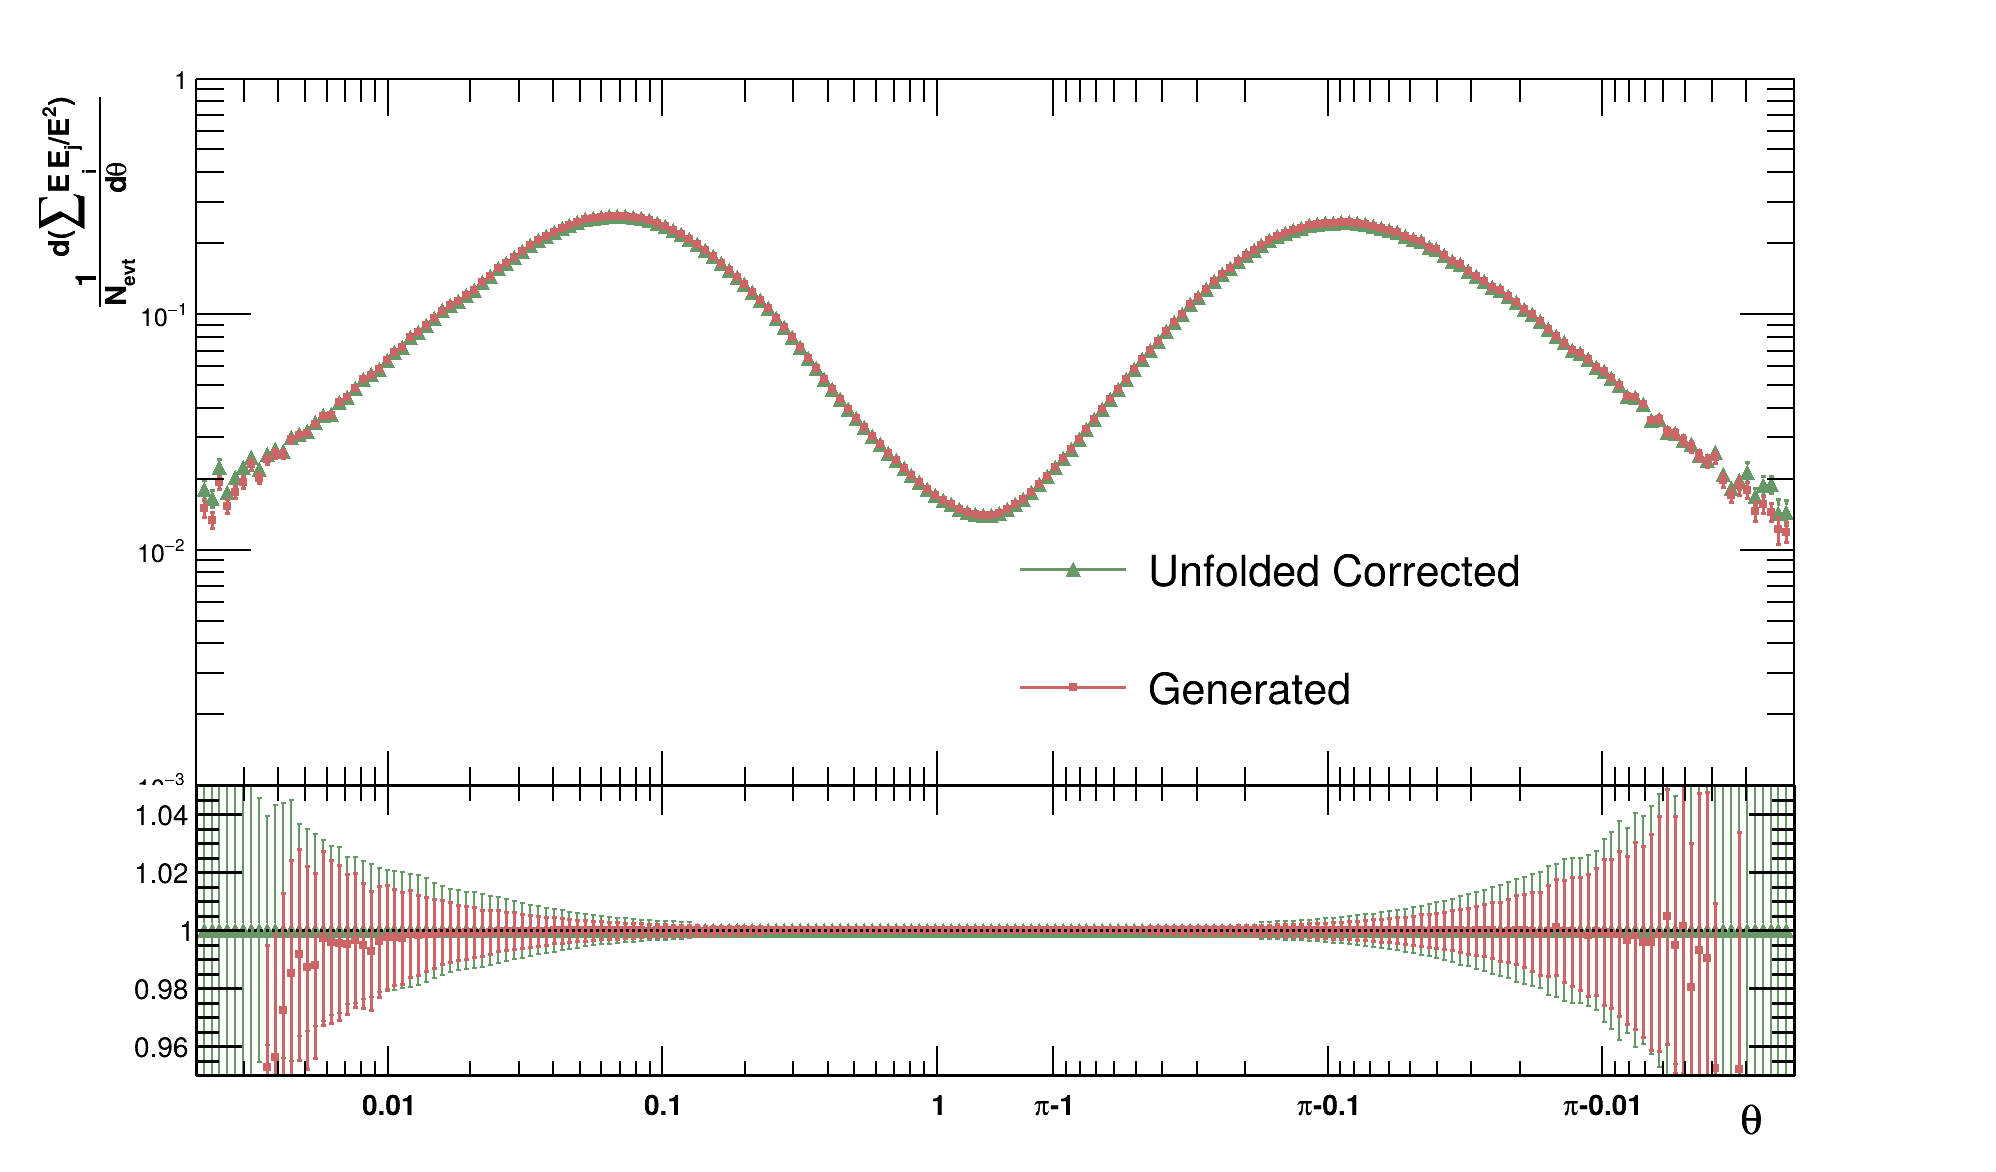

Info in <TCanvas::Print>: png file EEC_cor_comp.png has been created


In [9]:
unfoldfname1 = 'unfolded_LEP1MC1994_v14_bin2.root'
unfoldfname2 = 'hgenBefore_LEP1MC1994_recons_aftercut.root'

responsefname = 'response_LEP1MC1994_v14.root'
responsefname2 = 'response_LEP1MC1994_v14.root'

infile1 = ROOT.TFile(unfoldfname1)
infile2 = ROOT.TFile(unfoldfname2)
responsefile = ROOT.TFile(responsefname)
#responsefile2 = ROOT.TFile(responsefname2)
normalization = responsefile.Get('counter').GetBinContent(2)
#normalization2 = responsefile2.Get('counter').GetBinContent(2)
normalization2 = file1.Get('N').GetBinContent(2)

hdata1 = prepare_histogram(infile1, 'UNFOLD_Eij_Bin', eijbins2, normalization)
#hdata2 = prepare_histogram(infile2, 'UNFOLD_Eij_Bin', eijbins2, normalization2)
hdata2 = infile2.Get('EEC_r')

hdata2.Scale(1./normalization2)
hdata2 = divideBinWidth(hdata2)

corr = [x * y * z for x, y, z in zip(corr_bin, corr_trk, corr_evt)]
corr2 = [x * y for x, y in zip(corr_bin, corr_evt2)]

nb = hdata1.GetNbinsX()
for b in range(nb):
    #corr[b]=1
    corr2[b]=1
    hdata1.SetBinContent(b+1, hdata1.GetBinContent(b+1)*corr[b])
    hdata1.SetBinError(b+1, hdata1.GetBinError(b+1)*corr[b])
    hdata2.SetBinContent(b+1, hdata2.GetBinContent(b+1)*corr2[b])
    hdata2.SetBinError(b+1, hdata2.GetBinError(b+1)*corr2[b])

# --- 4. Create TGraphErrors for Data and Ratios ---

data1_eec = ROOT.TGraphErrors()
data2_eec = ROOT.TGraphErrors()

ratio1   = ROOT.TGraphErrors()
ratio2   = ROOT.TGraphErrors()


# Fill TGraphErrors using the helper function
fill_TGraph(data1_eec, hdata1)
fill_TGraph(data2_eec, hdata2)

# Create ratio graphs: here we use hdata1 as a denominator for all ratios.
bins = []
eecs = []
errs = []
for b in range(nb):
    x_val = hdata1.GetBinCenter(b+1)
    den = hdata1.GetBinContent(b+1) if hdata1.GetBinContent(b+1) != 0 else 1.0  # avoid div-by-zero
    bins+=[hdata1.GetBinCenter(b+1)]
    eecs+=[hdata1.GetBinContent(b+1)]
    errs+=[hdata1.GetBinError(b+1)]
    ratio1.SetPoint(b, b+0.5, hdata1.GetBinContent(b+1)/den)
    ratio1.SetPointError(b, 0, hdata1.GetBinError(b+1)/den)
    ratio2.SetPoint(b, b+0.5, hdata2.GetBinContent(b+1)/den)
    ratio2.SetPointError(b, 0, hdata2.GetBinError(b+1)/den)

# --- 6. Set Up ROOT Canvas and Style ---

ROOT.gStyle.SetLineWidth(0)
ROOT.gStyle.SetOptStat(0)

xmin, xmax = 0., 200.
ymin, ymax = 0.001, 1.
rymin, rymax = 0.95, 1.05
rylen = rymax - rymin

c4 = ROOT.TCanvas("tmp", "", 0, 0, 2000, 1200)
c4.Divide(1, 2)
pad1 = ROOT.TPad("", "", 0, 0.33, 1, 1)
pad2 = ROOT.TPad("", "", 0, 0, 1, 0.33)
pad1.SetFrameLineWidth(0)
pad2.SetFrameLineWidth(0)
pad1.SetBottomMargin(0.0)
pad2.SetTopMargin(0.0)
pad2.SetBottomMargin(0.25)
pad1.Draw()
pad2.Draw()

# --- 7. Draw Upper Pad (Data) ---

pad1.cd()
pad1.SetLogy()
data1_eec.SetMarkerSize(2)
data1_eec.SetMarkerStyle(22)
data1_eec.SetMarkerColor(ROOT.kGreen-5)
data1_eec.SetLineColor(ROOT.kGreen-5)
data1_eec.SetLineWidth(3)
data1_eec.GetXaxis().SetTickLength(0)
data1_eec.GetXaxis().SetLabelSize(0)
data1_eec.GetXaxis().SetRangeUser(xmin, xmax)
data1_eec.GetYaxis().SetRangeUser(ymin, ymax)
data1_eec.Draw("ap")

data2_eec.SetMarkerSize(1)
data2_eec.SetMarkerStyle(21)
data2_eec.SetMarkerColor(ROOT.kRed-6)
data2_eec.SetLineColor(ROOT.kRed-6)
data2_eec.SetLineWidth(3)
data2_eec.Draw("samep")


# Redraw again to ensure proper layering
data1_eec.Draw("samep")
data2_eec.Draw("samep")


# Draw additional axis and lines
f = ROOT.TF1("f", "log10(x)", ymin, ymax)
newaxis0 = ROOT.TGaxis(p_indices[0], ymin, p_indices[0], ymax, "f", 505, "-G")
newaxis0.SetLabelSize(0)
newaxis0.SetLineWidth(2)
newaxis0.Draw()

newaxis1 = ROOT.TGaxis(xmax - p_indices[0], ymin, xmax - p_indices[0], ymax, "f", 505, "+G")
newaxis1.SetLabelSize(0)
newaxis1.SetLineWidth(2)
newaxis1.Draw()

l0 = ROOT.TLine(xmin, ymax, xmax, ymax)
l0.SetLineWidth(2)
l0.Draw()

l1 = ROOT.TLine(xmin, ymin, xmax, ymin)
l1.SetLineWidth(2)
l1.Draw()

# Draw tick marks based on t_labels and indices
ticks = []
for pos in indices:
    ticks.extend(draw_lines([pos], 0.7*ymax, ymax))
    ticks.extend(draw_lines([pos], ymin, ymin + ymin*0.4))

for pt in p_indices:
    ticks.extend(draw_lines([xmin+pt], 0.8*ymax, ymax))
    ticks.extend(draw_lines([xmax-pt], 0.8*ymax, ymax))
    ticks.extend(draw_lines([xmin+pt], ymin, ymin + ymin*0.2))
    ticks.extend(draw_lines([xmax-pt], ymin, ymin + ymin*0.2))

txt1 = ROOT.TLatex()
txt1.SetTextSize(0.04)
txt1.SetTextAlign(22)
txt1.SetTextAngle(90)
txt1.DrawLatex(-14, 0.3*ymax, "#frac{1}{N_{evt}}#frac{d(#sumE_{i}E_{j}/E^{2})}{d#theta}")

legend = ROOT.TLegend(0.5, 0.05, 0.8, 0.35)
legend.AddEntry(data1_eec, "Unfolded Corrected", "alp")
legend.AddEntry(data2_eec, "Generated", "alp")
legend.SetTextSize(0.06)
legend.SetFillStyle(0)
legend.Draw("same")

# --- 8. Draw Lower Pad (Ratio) ---

pad2.cd()
ratio1.SetLineWidth(2)
ratio1.GetXaxis().SetTickLength(0)
ratio1.GetXaxis().SetLabelSize(0)
ratio1.GetXaxis().SetRangeUser(xmin, xmax)
ratio1.SetMarkerSize(2)
ratio1.SetMarkerStyle(22)
ratio1.SetMarkerColor(ROOT.kGreen-5)
ratio1.SetLineColor(ROOT.kGreen-5)
ratio1.Draw("ap")
ratio1.GetYaxis().SetRangeUser(rymin, rymax)
ratio1.GetYaxis().SetNdivisions(505)
ratio1.GetYaxis().SetLabelSize(0.08)

ratio2.SetMarkerSize(1)
ratio2.SetMarkerStyle(21)
ratio2.SetMarkerColor(ROOT.kRed-6)
ratio2.SetLineColor(ROOT.kRed-6)
ratio2.SetLineWidth(3)
ratio2.Draw("samep")


# Draw tick labels along x-axis
for pos, lab in zip(indices, t_labels):
    tex = ROOT.TLatex()
    tex.SetTextSize(0.08)
    tex.SetTextAlign(22)
    tex.DrawLatex(pos, rymin - 0.1*rylen, lab)
    tick = ROOT.TLine(pos, rymin, pos, rymin + rylen*0.1)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks.append(tick)

for pos in indices:
    tick = ROOT.TLine(pos, rymax - rylen*0.1, pos, rymax)
    tick.SetLineWidth(2)
    tick.Draw()
    ticks.append(tick)

for pt in p_indices:
    ticks.extend(draw_lines([xmin+pt], rymin, rymin+rylen*0.05))
    ticks.extend(draw_lines([xmax-pt], rymin, rymin+rylen*0.05))
    ticks.extend(draw_lines([xmin+pt], rymax-rylen*0.05, rymax))
    ticks.extend(draw_lines([xmax-pt], rymax-rylen*0.05, rymax))

newaxis2 = ROOT.TGaxis(p_indices[0], rymin, p_indices[0], rymax, rymin, rymax, 505, "-L")
newaxis2.SetLabelSize(0)
newaxis2.SetLineWidth(3)
newaxis2.Draw()

newaxis3 = ROOT.TGaxis(xmax-p_indices[0], rymin, xmax-p_indices[0], rymax, rymin, rymax, 505, "+L")
newaxis3.SetLabelSize(0)
newaxis3.SetLineWidth(3)
newaxis3.Draw()

l2 = ROOT.TLine(0, rymax, 200, rymax)
l2.SetLineWidth(3)
l2.Draw()

l3 = ROOT.TLine(0, rymin, 200, rymin)
l3.SetLineWidth(3)
l3.Draw()

l4 = ROOT.TLine(0,1,200,1)
l4.SetLineWidth(3)
l4.SetLineStyle(2)
l4.Draw()

txt2 = ROOT.TLatex()
txt2.SetTextSize(0.12)
txt2.SetTextAlign(22)
txt2.DrawLatex(195, rymin - 0.15*rylen, "#theta")

c4.SaveAs('EEC_cor_comp.png')
c4.Close()
clear_output(wait=True)
display(Image("EEC_cor_comp.png"))